***
# MF204 : Changements climatiques $-$ ENSTA $-$ 2022-2023

https://ecampus.paris-saclay.fr/course/view.php?id=18625

Responsable du cours : Nathaelle Bouttes (nathaelle.bouttes@lsce.ipsl.fr)

Responsable du TD : Cécile Agosta (cecile.agosta@lsce.ipsl.fr)

**Quelques commentaires sur les Notebook.**
Ce texte est rédigé sous la forme d'un notebook. Un notebook comporte des cellules de texte et des cellules de code, ici en Python. Quelques raccourcis clavier et remarques utiles:

- `CTRL+Entrée`: exécute la cellule de code, et affiche son résultat.
- `Tab`: Si l'on `Tab` après avoir tapé les premières lettres d'un nom de fonction, le système propose une liste de possibilités (ce qui peut permettre d'éviter des erreurs de frappe)
- `MAJ+Tab`: Affiche la documentation sur la fonction. Très utile pour ne pas se tromper sur l'ordre des paramètres. On peut voir une documentation plus complète en cliquant sur le '+'.
- `CTRL+s`: Enregistrer les modifications apportées au Notebook.
- Le symbole `[*]` à côté d'une cellule de code indique que le noyau Python est toujours en train de calculer. On peut l'interrompre via `Kernel -> Interrupt` ou le redémarrer via `Kernel -> Restart`. Le noyau Python repart alors de zéro, et il faut donc relancer les cellules antérieures à celle sur laquelle on travaillait.

Une aide complète, ainsi que la documentation de Python et Numpy, est disponible dans le menu `Aide`.
***

# ===== CONFIGURATION PYTHON & TEST =====
---

## Configuration du python abo
Cette configuration permet d'avoir les bons packages avec les bons numéros de version.

Suivez les étapes décrites ici : https://climat.notion.site/MF204-Installation-python-Nov-2022-86c07ab8021448f180ebf9a0b46cb2ca

Attention, si vous êtes ici c'est que vous avez créé l'environnement conda `abo` et le noyau `abo` en suivant les étapes 1-6 ci-dessus.

N'oubliez pas d'activer votre noyau `abo` dans ce Jupyter Notebook : `Noyau` → `Changer de Noyau` → `abo`

## Test des modules python
Chargez les modules pythons utiles pour la suite du TD :

In [1]:
# %reset
# python module needed
# = import modules ============================= #
# import netCDF4 as nc # read and write netcdf files
# from os.path import exists # check if file exists
import matplotlib.pyplot as plt  # interactive plots
import cartopy.crs as ccrs  # spatial projections
import numpy as np  # arrays
import xarray as xr  # netcdf data
import datetime  # time decoding

# =============================================== #
# define the figure size
plt.rcParams['figure.figsize'] = [9., 6.]

In [2]:
from platform import python_version

print(python_version())

3.10.8


Lancez les cellules ci-dessous. Si vous avez des erreurs, contactez-moi : cecile.agosta@lsce.ipsl.fr

In [3]:
# read grid dataset with xarray
grid = xr.open_dataset('./in/grid_1x1.nc4')

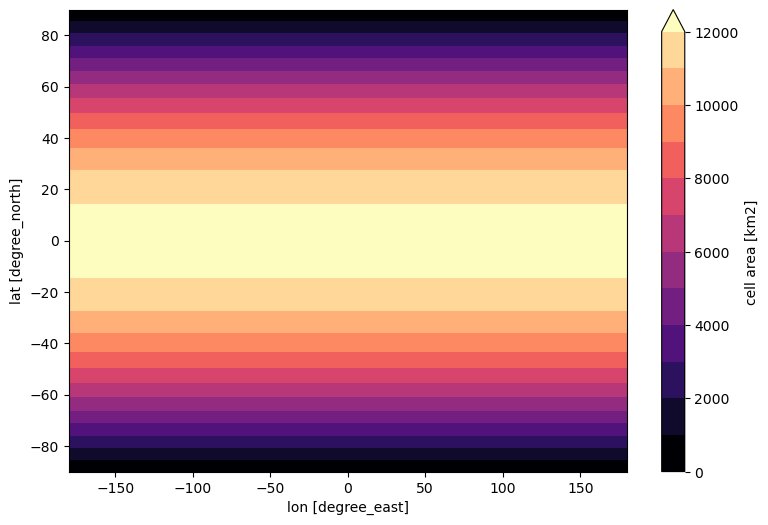

In [4]:
# plot a map of the variable `area` with discrete colormap
grid['area'].plot.contourf(levels=np.arange(0, 12000+1000, 1000), cmap='magma')

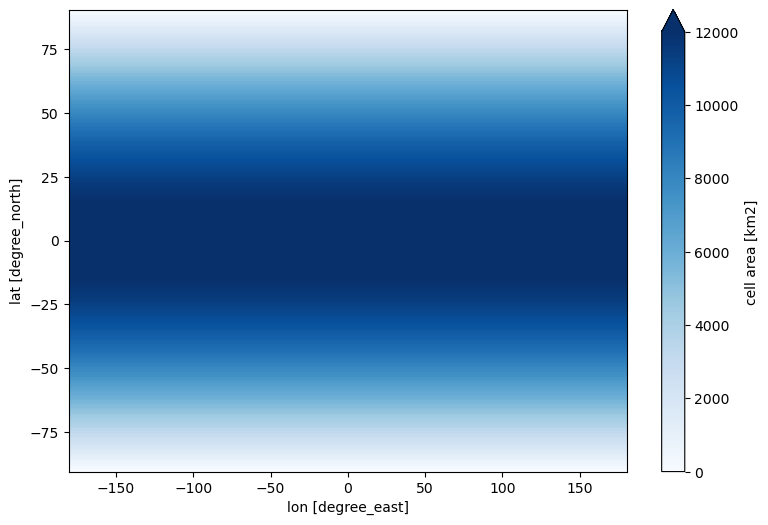

In [5]:
# plot a map of the variable `area` with continuous colormap
grid['area'].plot.pcolormesh(vmin=0, vmax=12000, cmap='Blues')

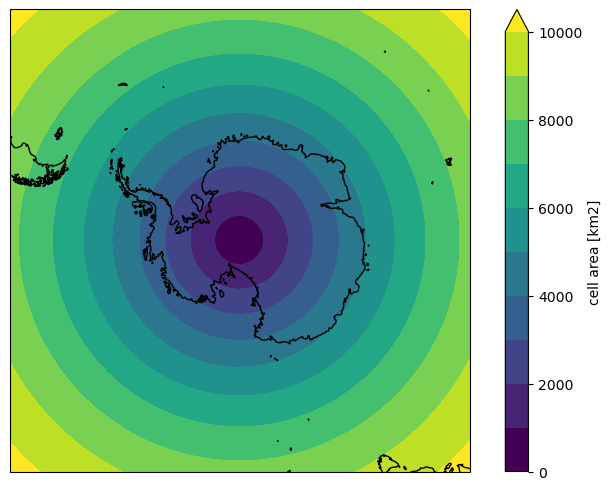

In [6]:
# test a projection
data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -48], crs=ccrs.PlateCarree())
grid['area'].plot.contourf(levels=np.arange(0, 10000+1000, 1000), extend='max', transform=data_crs)
ax.coastlines(resolution='50m')

## Test de lecture des fichiers

In [7]:
test = xr.open_dataset('./in/pr_IPSL-CM6A-LR_historical-ssp585_1850-2100_1x1_DJF.nc')['pr']

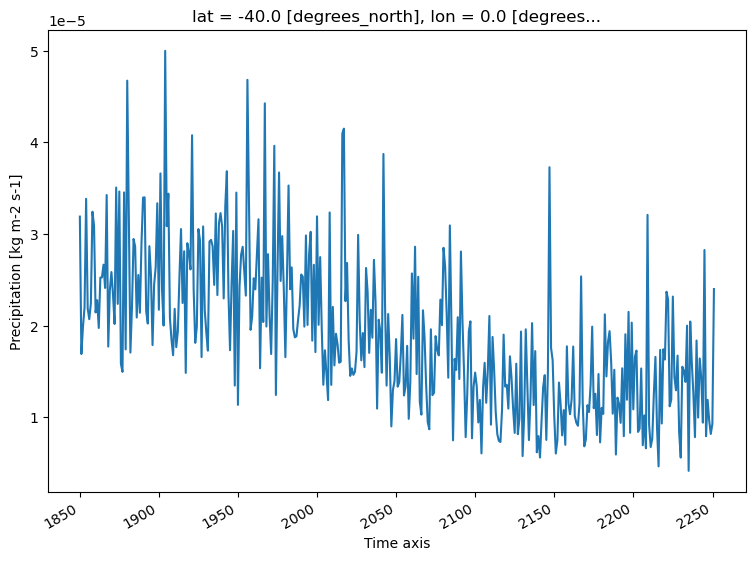

In [8]:
test.sel(lon=0, lat=-40, method='nearest').plot()

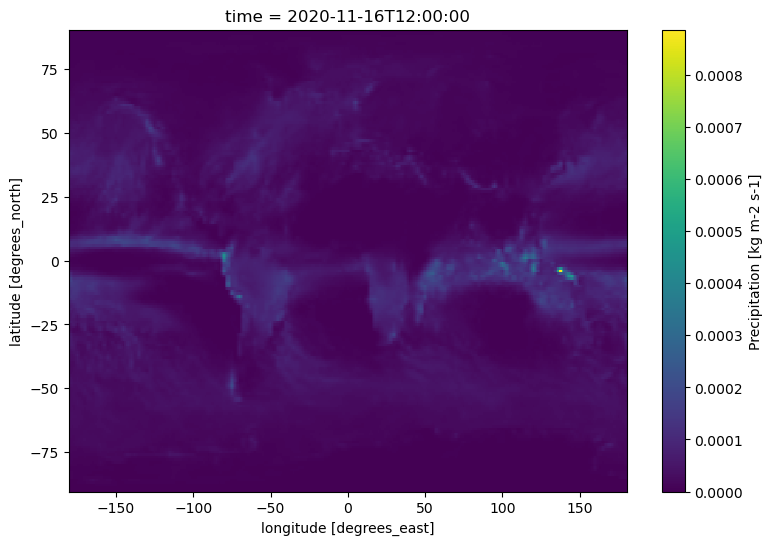

In [9]:
test.sel(time="2020").plot()

# ===== END OF TEST =====
---

# Partie 0 : Objectifs du TD

## 0.1. Contexte des simulations climatiques

L'objectif de ce TD est de comprendre comment sont réalisées les projections climatiques au cours du 21ème siècle. Pour cela nous utiliserons les **sorties de modèles de climat** utilisés pour réaliser les rapports du Groupe d'experts intergouvernemental sur l'évolution du climat (GIEC) / Intergovernmental Panel on Climate Change (IPCC).

Les modèles de climats utilisés pour réaliser les rapports du GIEC suivent un protocol commun défini au sein des exercices [CMIP](https://www.wcrp-climate.org/wgcm-cmip) (*Coupled Model Intercomparison Project*), qui sont des exercices d'intercomparaison de **modèles de climat couplés océan-atmosphère (Global Climate Models, GCMs)**, appelés **Earth System Models (ESMs)** quand ils incluent la modélisation de processus chimiques et biologiques relatifs au cycle du carbone. Ces exercices définissent notamment des scénarios de forçages radiatifs communs à tous les modèles et une nomenclature commune pour les champs climatiques modélisés (nom des variables, caractéristiques des grilles, etc.).

Le dernier rapport du GIEC ([IPCC AR6, 2021](https://www.ipcc.ch/report/sixth-assessment-report-working-group-i/)) est basé sur l'excercice [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6). Une petite vidéo d'introduction aux simulations CMIP [ici](https://www.wcrp-climate.org/wgcm-cmip). Nous utiliserons certaines de ces simulations au cours de ce TD.

Une autre ressource interessante : [https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained)

## 0.2. Choix d'une variable climatique et d'une région à étudier

**Nous nous concentrerons sur 4 variables de surface :**
   - précipitations (`pr`)
   - température de l'air en surface (`tas`, pour *surface air temperature*)
   - température de surface des océans (`tos`, pour *surface ocean temperature*)
   - concentration de glace de mer (`siconc`, pour *sea ice concentration*)

Nous considérons ces variables en moyennes annuelle et saisonières. Pour simplifier le traitement de données, les variables ont été préalablement interpollées sur une grille régulière longitude/latitude de 1°$\times$1° et moyennées par saison (DJF et JJA) et en valeurs annuelles (annual) à partir des valeurs mensuelles.

**Informations importantes :** vous travaillerez par groupe de 2 pour faciliter l'entraide, mais chacun doit travailler sur son propre notebook et son propre ordinateur.


**Q0.2.1** Renommez votre fichier sous la forme : votre-nom-de-famille_mf204.ipynb (par exemple : agosta_mf204.ipynb)

**Q0.2.2** Choisissez **une région par binôme** et **un couple variable/région par personne**, parmi ceux proposés ci-dessous. Inscrivez vos noms à côté du numéro choisi au tableau.
   - Binôme 1, 1a : Température en Amérique centrale et Mexique
   - Binôme 1, 1b : Précipitations en Amérique centrale et Mexique
   - Binôme 2, 2a : Température au Groenland
   - Binôme 2, 2b : Précipitations au Groenland
   - Binôme 3, 3a : Glace de mer en Arctique
   - Binôme 3, 3b : Température des océans en Arctique
   - Binôme 4, 4a : Température de l'océan pacifique central (Polynésie et autour)
   - Binôme 4, 4b : Précipitations de l'océan pacifique central (Polynésie et autour)
   - Binôme 5, 5a : Température de l'océan atlantique central (Antilles et autour)
   - Binôme 5, 5b : Précipitations de l'océan atlantique central (Antilles et autour)
   - Binôme 6, 6a : Température en Méditerranée
   - Binôme 6, 6b : Précipitations en Méditerranée
   - Binôme 7, 7a : Température de l'ouest de l'Amérique du Sud
   - Binôme 7, 7b : Précipitations de l'ouest de l'Amérique du Sud
   - Binôme 8, 8a : Température de l'Amazonie
   - Binôme 8, 8b : Précipitations de l'Amazonie
   - Binôme 9, 9a : Température en Asie du Sud-Est
   - Binôme 9, 9b : Précipitations en Asie du Sud-Est
   - Binôme 10, 10a : Température en Afrique Saharienne
   - Binôme 10, 10b : Précipitations en Afrique Saharienne

**Q0.2.3** **Seulement si vous travaillez sur votre ordi perso :** Chargez votre variables à partir de l'archive suivante et mettez le dossier dans le dossier `./in/` du TD :
   - précipitations (`pr`) : https://sharebox.lsce.ipsl.fr/index.php/s/vcJMIulyoX825GW
   - temparature de l'air en surface (`tas`) : https://sharebox.lsce.ipsl.fr/index.php/s/AneLCHPOZBswW7T
   - température de surface des océans (`tos`) : https://sharebox.lsce.ipsl.fr/index.php/s/OTSVcUGBmK5OSRH
   - concentration de glace de mer (`siconc`) : https://sharebox.lsce.ipsl.fr/index.php/s/dgSzEWhLRUphglx

Précision : vous devez placer le dossier téléchargé, qui a le même nom que votre variable, dans le dossier `./in/`.
Par exemple, si vous travaillez sur les précipitations, vous devez mettre le dossier téléchargé `pr` dans `./in/`.
Dans ce dossier il y a 15 fichiers : 5 modèles et 3 saison par modèle.

### **== CONFIG COLAB SEULEMENT ==**

**Dans votre Google Drive :**
* Allez dans le dossier `Shared With Me` : https://drive.google.com/drive/shared-with-me 
* Clic-droit sur de dossier partagé "in" -> `Add shortcut to Drive` -> `My Drive`

Ci-dessus la cellule permet de lire votre Google Drive depuis Colab. Il faut :
* lancer la cellule
* cliquer sur le lien donné
* cela ouvre une fenêtre qui vous demande vos identifiants Google pour vos connecter à votre Google Drive : connectez-vous
* vous obtenez un long code qui faut copier et coller dans la boite de texte située sous "Enter your authorization code:"

In [10]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [11]:
#! ln -s ./drive/MyDrive/in .
#! mkdir fig

Ci-dessous, l'installation de cartopy. Il peut y avoir un message d'erreur en rouge lors de l'installation de Shapely (ERROR: pip's dependency resolver...), mais ce n'est pas un problème.

In [12]:
#! pip install --no-binary shapely shapely --force
#! pip install nc-time-axis==1.4.0
#! pip install cartopy

**== FIN DE LA CONFIG COLAB ==**

## 0.3 Chargement des modules python
Chargez les modules pythons utiles pour la suite du TD :

In [13]:
# %reset
# python module needed
# = import modules ============================= #
# import netCDF4 as nc # read and write netcdf files
# from os.path import exists # check if file exists
import matplotlib.pyplot as plt  # interactive plots
import cartopy.crs as ccrs  # spatial projections
import numpy as np  # arrays
import xarray as xr  # netcdf data
import datetime  # time decoding

# =============================================== #
# define the figure size
plt.rcParams['figure.figsize'] = [9., 6.]

---
# Partie 1: Définir un domaine spatial et tracer une climatologie avec une projection adaptée


## 1.1. Lire un fichier netcdf

**Qu'est-ce qu'un netcdf ?** (un petit résumé de la page [Wikipedia](https://fr.wikipedia.org/wiki/NetCDF))

Netcdf est un format de données ouvert qui permet la création, l'accès et le partage de données scientifiques stockées sous la forme de tableaux. Le format de données est « auto-documenté » c'est-à-dire qu'il existe un en-tête qui décrit la disposition des données dans le reste du fichier, et en particulier des tableaux de données. Ce format est couramment utilisé dans des applications de climatologie, de météorologie et d'océanographie (ex., prévision météorologique, changement climatique et applications des S.I.G.).

Mieux vaut une application pratique que de longs discours. Que trouve-t'on dans un netcdf ?

**Q1.1.1.** Lire un fichier netcdf et comprendre les variables stockées

a) Ouvrir le fichier ./in/grid_1x1.nc4

In [14]:
# read grid dataset with xarray
grid = xr.open_dataset('./in/grid_1x1.nc4')

b) Regarder ce qu'il y a dans le dataset `grid`

In [15]:
# look what's inside `grid`
grid

<xarray.Dataset>
Dimensions:  (lon: 361, lat: 181)
Coordinates:
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    area     (lat, lon) float32 ...

c) Donner un nom aux variables que nous allons utiliser souvent et regarder ce qu'il y a dedans

In [16]:
# longitude variable
lon1d = grid['lon']
# latitude variable
lat1d = grid['lat']
# grid cell area variable
area2d = grid['area']
# transform the lon and lat axes (1d variables) to 2d variables
lon2d = lon1d.broadcast_like(area2d)
lat2d = lat1d.broadcast_like(area2d)

In [17]:
# look what's in the variables lon1d, lat1d, area2d, lon2d and lat2d
lon1d

<xarray.DataArray 'lon' (lon: 361)>
array([-180., -179., -178., ...,  178.,  179.,  180.], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Attributes:
    units:    degree_east

In [18]:
lon1d.values

array([-180., -179., -178., -177., -176., -175., -174., -173., -172.,
       -171., -170., -169., -168., -167., -166., -165., -164., -163.,
       -162., -161., -160., -159., -158., -157., -156., -155., -154.,
       -153., -152., -151., -150., -149., -148., -147., -146., -145.,
       -144., -143., -142., -141., -140., -139., -138., -137., -136.,
       -135., -134., -133., -132., -131., -130., -129., -128., -127.,
       -126., -125., -124., -123., -122., -121., -120., -119., -118.,
       -117., -116., -115., -114., -113., -112., -111., -110., -109.,
       -108., -107., -106., -105., -104., -103., -102., -101., -100.,
        -99.,  -98.,  -97.,  -96.,  -95.,  -94.,  -93.,  -92.,  -91.,
        -90.,  -89.,  -88.,  -87.,  -86.,  -85.,  -84.,  -83.,  -82.,
        -81.,  -80.,  -79.,  -78.,  -77.,  -76.,  -75.,  -74.,  -73.,
        -72.,  -71.,  -70.,  -69.,  -68.,  -67.,  -66.,  -65.,  -64.,
        -63.,  -62.,  -61.,  -60.,  -59.,  -58.,  -57.,  -56.,  -55.,
        -54.,  -53.,

In [19]:
lat1d

<xarray.DataArray 'lat' (lat: 181)>
array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80., -79.,
       -78., -77., -76., -75., -74., -73., -72., -71., -70., -69., -68., -67.,
       -66., -65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55.,
       -54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43.,
       -42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32., -31.,
       -30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    units:    degree_north

## 1.2. Faire des plots rapides dans la projection d'origine

**Q.1.2.1.** Regarder rapidement les variables xarray avec `.plot()`.
Quelle est la projection des données ? Quel est le principal problème de cette projection ?

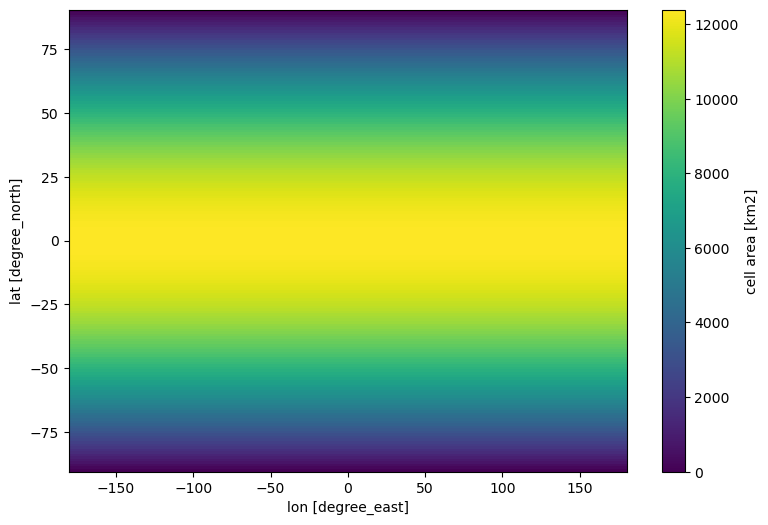

In [20]:
area2d.plot()

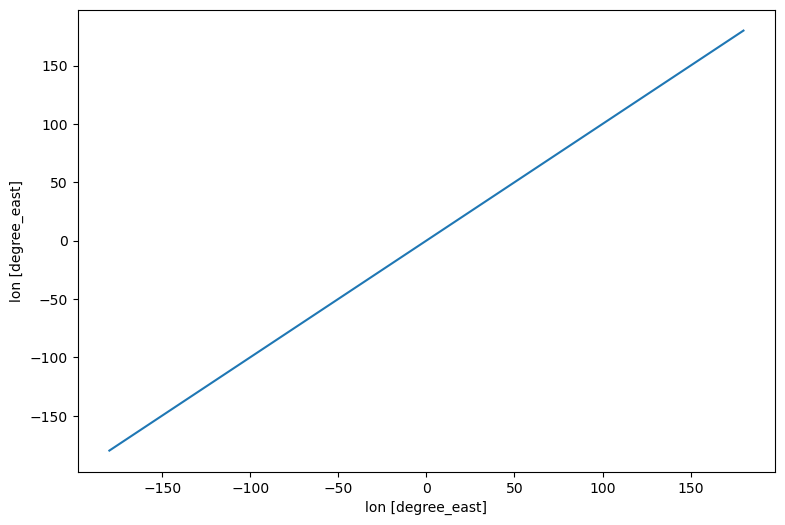

In [21]:
lon1d.plot()

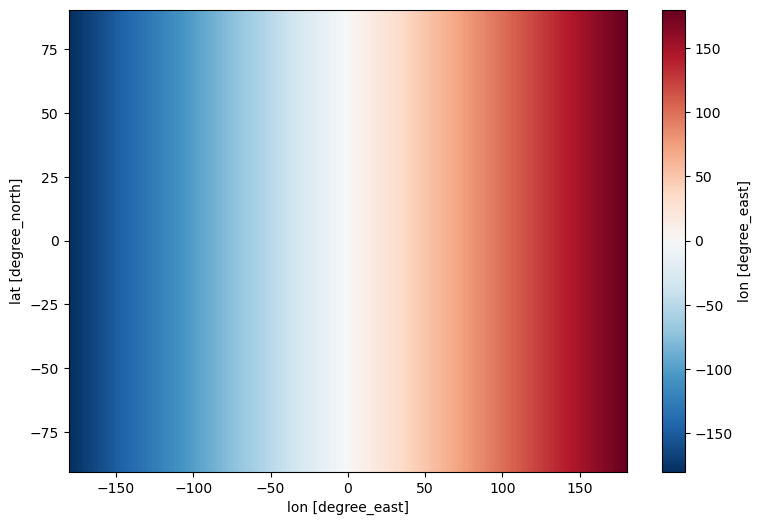

In [22]:
lon2d.plot()

**Q1.2.2.** Faire une "bonne carte" de l'aire des cellules.
La lisibilité des cartes est meilleure avec une échelle de couleur discrète, ayant une dizaine d'incrément, une vingtaine max.

a) Faire une carte avec les fonctions matplotlib.pyplot :
   * échelle discrète de couleur : `plt.contourf()`
   * légende de l'échelle de couleur : `plt.colorbar()`
   * un label de légende indiquant la variable représentée et son unité : `plt.colorbar(label='my label')`
   * label de l'axe x : `plt.xlabel('my label')`
   * label de l'axe y : `plt.ylabel('my label')`
   * titre de la figure, qui doit donner toutes les autres infos nécessaire à son interprétation : `plt.suptitle('my title')`

### make a first map
area2d.plot.contourf(levels=np.arange(0, 12000+1000, 1000), cmap='magma')
#area2d.plot.colorbar(location='left',orientation='vertical')
area2d.plot.xlabel('longitude')
area2d.plot.ylabel('latitude')
area2d.plot.suptitle('Area 2D')

b) Ajustez votre échelle de couleur pour qu'elle soit bien discrétisée :
   * choisir vmin, vmax, delta pour ajuster les incréments du `contourf` (`levels=`)
   * choisir l'option `extend` adaptée (`'min'`, `'max'` ou `'both'`).
Vous pouvez faire des tests.

Text(0.5, 0.98, 'area')

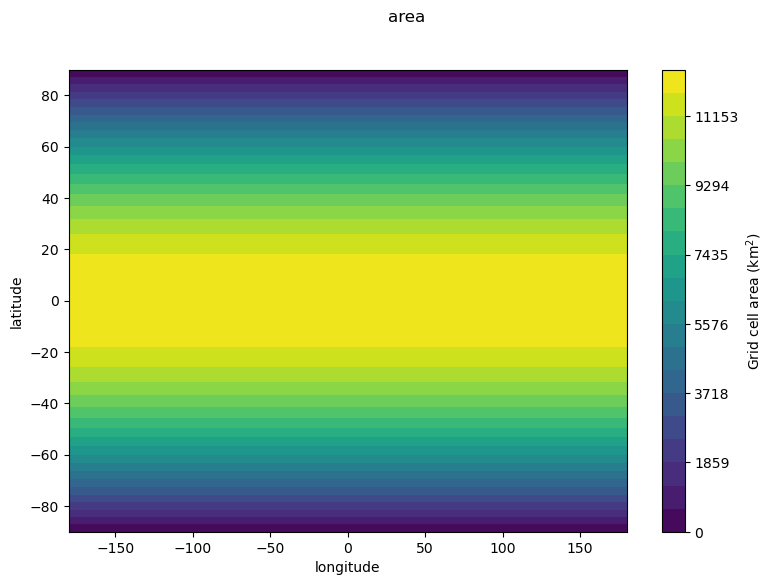

In [23]:
vmin = np.amin(area2d.values[:])
vmax = np.amax(area2d.values[:])
delta = (vmax-vmin)/20
levels = np.arange(vmin, vmax + delta, delta)
# here your new map using levels and extend in `plt.contourf()`
# =============================================================
plt.contourf(lon1d, lat1d, area2d,levels=levels)
plt.colorbar(label='Grid cell area (km$^{2}$)')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.suptitle("area")

## 1.3. Faire une carte dans une projection adaptée avec cartopy

L'objectif de cette section est de créer une carte avec une projection correcte pour l'ensemble du globe, de définir votre région d'intérêt, puis de créer une carte avec une projection correcte pour votre région.

Les projections disponibles dans cartopy sont listées ici : https://scitools.org.uk/cartopy/docs/v0.18/crs/projections.html

Et pour une meilleure description des projections, vous pouvez aller voir là : https://matplotlib.org/basemap/users/mapsetup.html

a) Choisir une projection et la tracer sur une carte

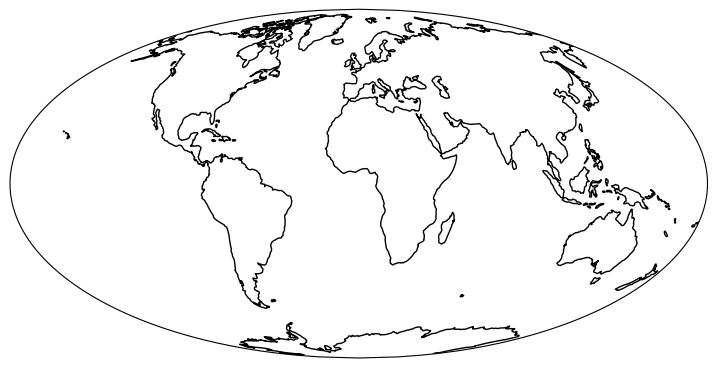

In [24]:
# plot a map with a nice projection using cartopy #
# =============================================== #
# indicate the Coordinate Reference System (crs) of your input data
data_crs = ccrs.PlateCarree()
# choose a projection
# e.g. a global equal-area projection: Mollweide (https://matplotlib.org/basemap/users/moll.html)
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines()

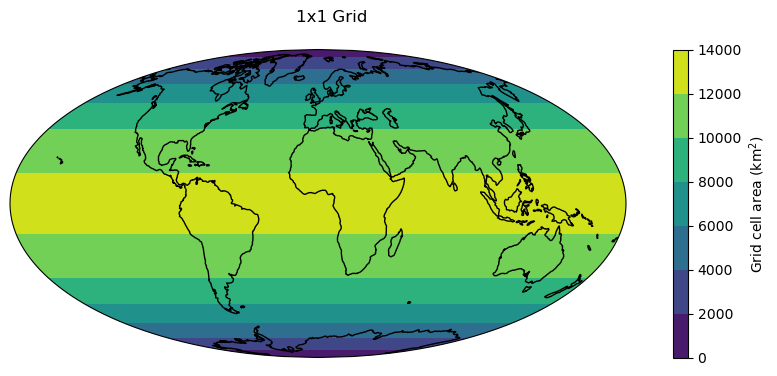

In [25]:
# test this projection
fig = plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.Mollweide())
plt.contourf(lon1d, lat1d, area2d, transform=data_crs)
plt.colorbar(label='Grid cell area (km$^{2}$)')
ax.coastlines()
title = fig.suptitle('1x1 Grid')

In [26]:
# add levels and extend
vmin, vmax, delta = vmin, vmax, delta
levels = np.arange(vmin, vmax+delta, delta)
fig = plt.figure(figsize=(12, 4))
...

Ellipsis

<Figure size 1200x400 with 0 Axes>

b) Nous créeons maintenant une fonction `shade` qui regroupe toutes ces commandes et qui permettra de faire des cartes automatiquement par la suite.

In [27]:
# define a shade function
def shade(var2d, var_name='', units='', title='', vmin=None, vmax=None, delta=None, cmap='viridis', \
          extend='both', projection=ccrs.Mollweide()):
    """Shade the 2-dimensional variable var2d with a nice projection and colorbar.
    Parameters
    ----------
    var2d : np.array or xarray
        2-dimensional array
    var_name : str, optional
        Name of the ploted variable.
    units : str, optional
        Units of the ploted variable.
    title : str, optional
        Title of the graph. Should describe the specificities of the graph (model, period, etc.).
    vmin : real, default: minimum of var2d
        Minimum value of the colorbar.
    vmax : real, default: maximum of var2d
        Maximum value of the colorbar.
    delta : real, default: var2d range (max - min) divided by 10
        Increment of the colorbar.
    cmap : str, default: default matplotlib cmap 'viridis'
        Name of the colormap.
    extend : str
        Define the extremity of the colorbar, can be 'min' or 'max' or 'both' or 'neither'
    projection : projection, default: ccrs.Mollweide()
        Define the projection to use to present the data
    Returns
    -------
    a matplotlib figure
    """
    #fig = plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=projection)
    ax.set_global()  # to show the whole Earth
    # define the colorbar
    vmin = var2d.min() if vmin is None else vmin
    vmax = var2d.max() if vmax is None else vmax
    # default delta give 10 increments from vmin to vmax
    delta = (vmax - vmin) / 10. if delta is None else delta
    levels = np.arange(vmin, vmax + delta, delta)
    # plot
    plt.contourf(lon1d, lat1d, var2d, levels, vmin=vmin, vmax=vmax, extend=extend, cmap=cmap, transform=data_crs)
    plt.colorbar(label=var_name + ' (' + units + ')')
    ax.coastlines()
    fig.suptitle(title)
    fig

c) Test de la fonction shade

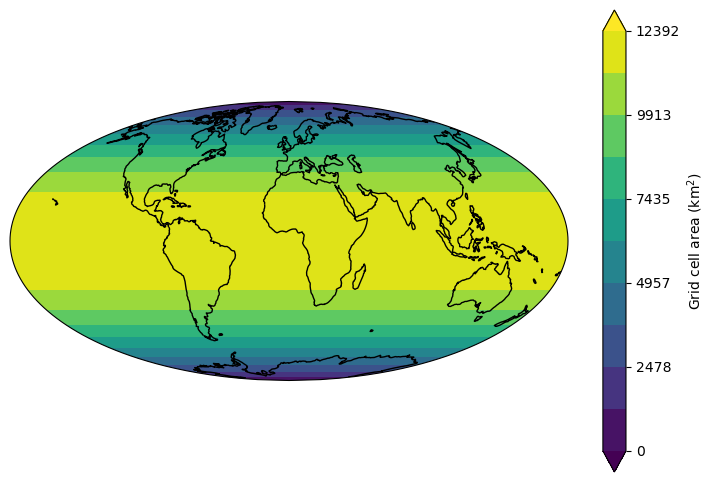

In [28]:
# test the shade function
shade(area2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, default projection')

**Q1.3.1** Ajustez les incréments de votre échelle de couleur ainsi que les extrémités de l'échelle

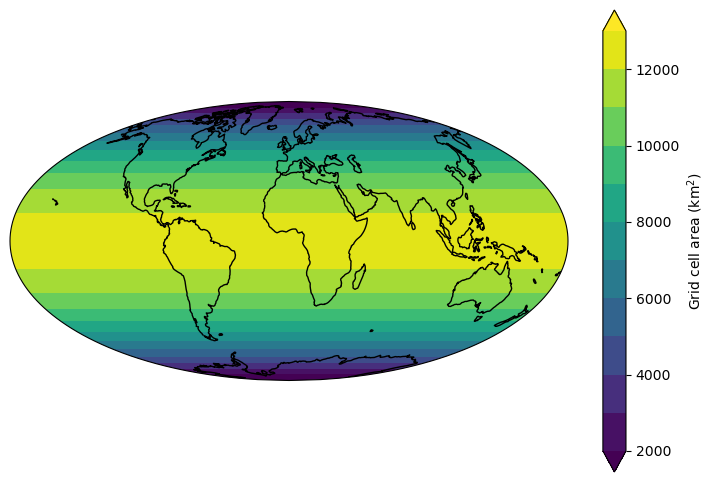

In [29]:
# choose nice levels for your colorbar
shade(area2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, default projection',\
      vmin=2000, vmax=13000, delta=1000, extend="both")

---
### Question bonus TD1

**Qbonus1** Tester différentes projections

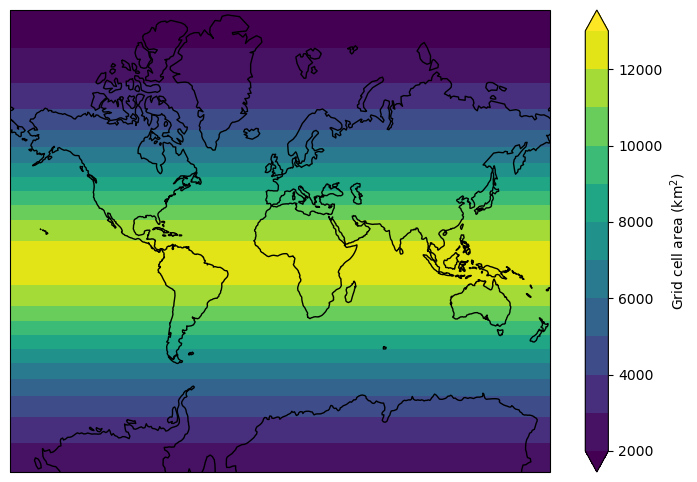

In [30]:
# Mercator projection
shade(area2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, Mercator',\
      vmin=2000, vmax=13000, delta=1000, extend="both", projection=ccrs.Mercator())

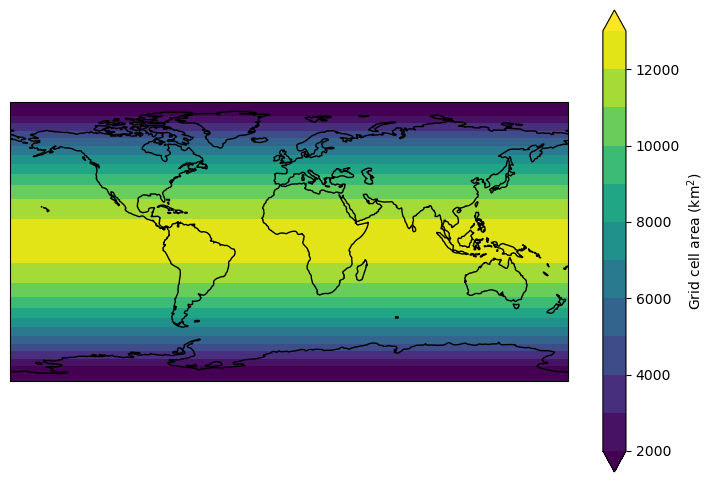

In [31]:
# PlateCarree projection
shade(area2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, PlateCarree',\
      vmin=2000, vmax=13000, delta=1000, extend="both", projection=ccrs.PlateCarree())

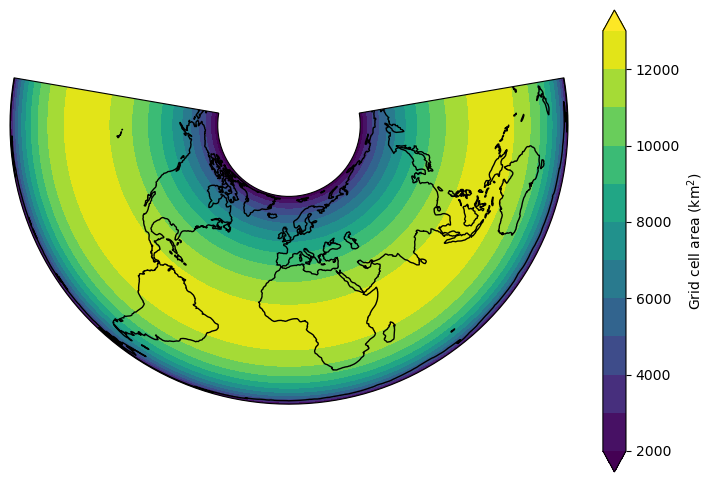

In [32]:
# AlbersEqualArea projection 
shade(area2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, AlbersEqualArea',\
      vmin=2000, vmax=13000, delta=1000, extend="both", projection=ccrs.AlbersEqualArea())

# ===== END OF TD1 =====
---

**Q1.3.2** Définissez votre région

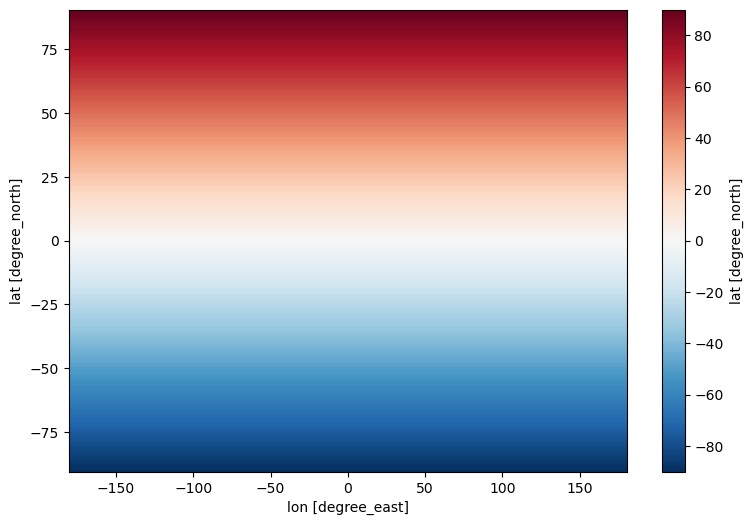

In [33]:
# a reminder of the 2d latitude field. You have the same for longitude.
lat2d.plot()

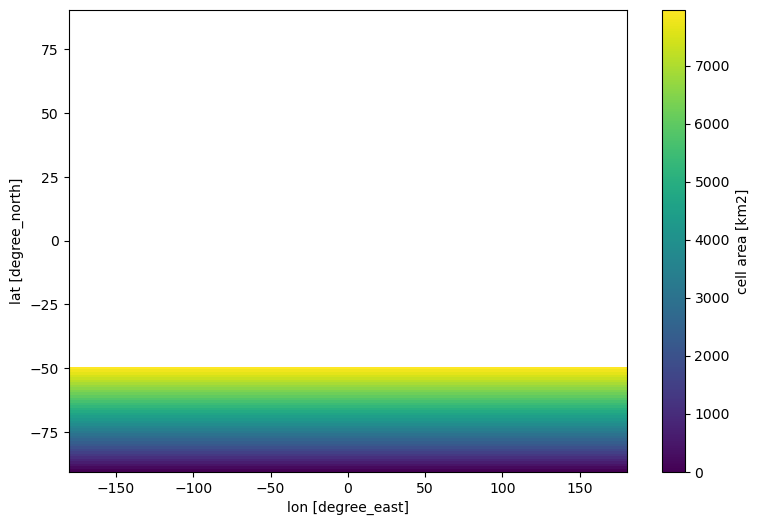

In [34]:
# define a region : 'Antartique'
region2d = (lat2d <= -50)
reg_name = 'Antartique'
# mask area2d everywhere except over your region
marea2d = area2d.where(region2d)
# have a quick look on marea2d
marea2d.plot()

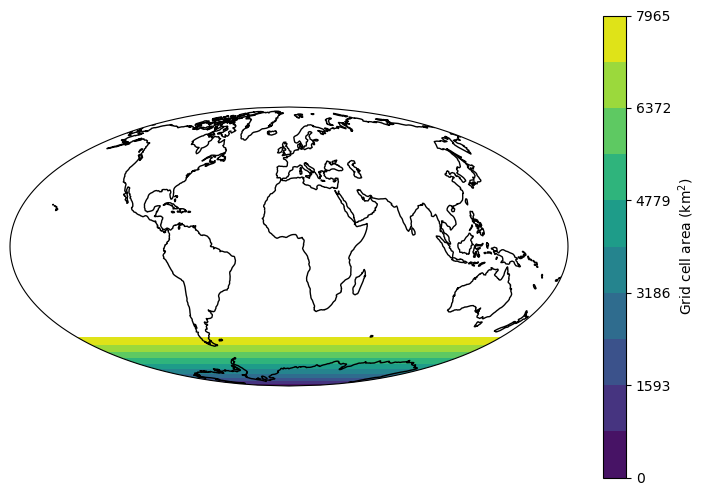

In [35]:
# plot your region with the shade function
shade(marea2d, var_name='Grid cell area', units='km$^2$', title='1x1 grid over ' + reg_name, extend='neither')

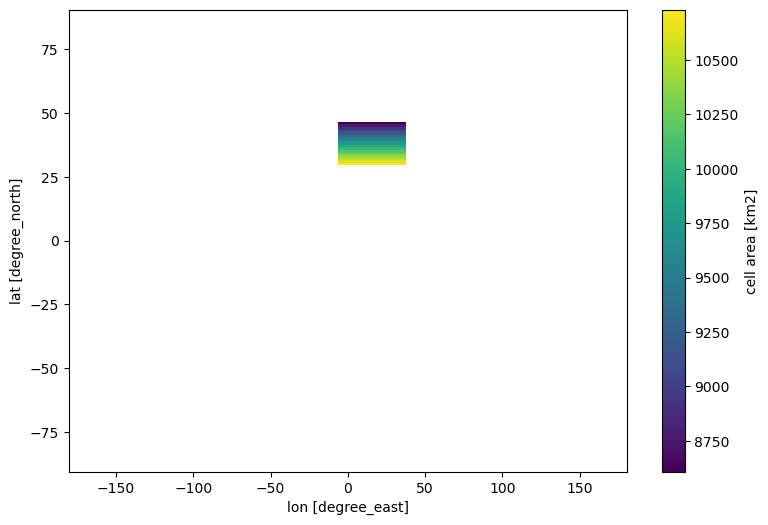

In [36]:
# define your own region
# define a region : 'Mediterranee'
region2d = (lon2d >= -6) & (lon2d <= 37) & (lat2d >= 30) & (lat2d <= 46)
reg_name = 'Mediterranee'
# mask area2d everywhere except over your region
marea2d = area2d.where(region2d)
# have a quick look on marea2d
marea2d.plot()

**Q1.3.3** Définissez une projection adaptée pour votre région. Par exemple, pour Arctique/Antarctique: NorthPolarStereo/SouthPolarStereo, ailleurs: Mercator ou Mollweide. Testez cette projection en plotant `marea2d`.

Ajustez les parallèles, les méridiens et leurs labels en customisant gridlines : https://www.net-analysis.com/blog/cartopyintro.html ; https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html?highlight=gridlines#cartopy.mpl.geoaxes.GeoAxes.gridlines

Un exemple pour l'Antarctique :

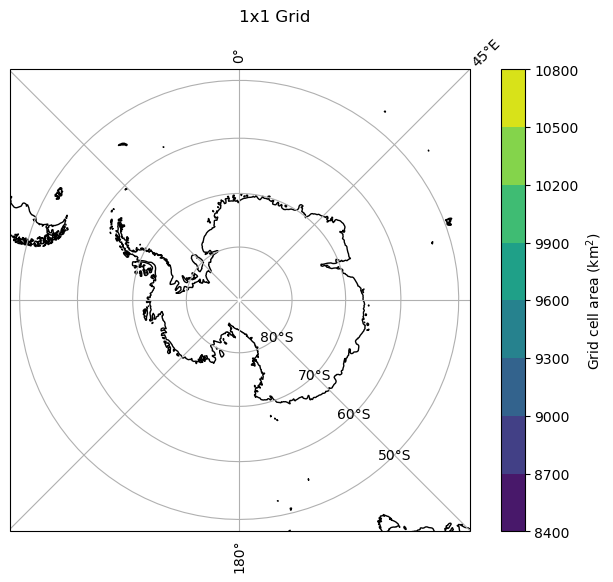

In [37]:
fig = plt.figure(figsize=(8, 6))
# define a new projection for your region.
ax = plt.axes(projection=ccrs.SouthPolarStereo())
# the extent is set in longitude/latitude, i.e. in projection "PlateCarree"
ax.set_extent([-180, 180, -90, -48], crs=ccrs.PlateCarree())
# test this projection
# `transform` gives the information of the *data projection*
# the *plot projection* is defined above
plt.contourf(lon1d, lat1d, marea2d, transform=data_crs)
plt.colorbar(label='Grid cell area (km$^{2}$)')
ax.coastlines(resolution='50m')
ax.gridlines(xlocs=np.arange(-180, 180, 45), ylocs=np.arange(-80, -40, 10), draw_labels=True, crs=data_crs)
title = fig.suptitle('1x1 Grid')

Adaptez cet exemple pour votre région :

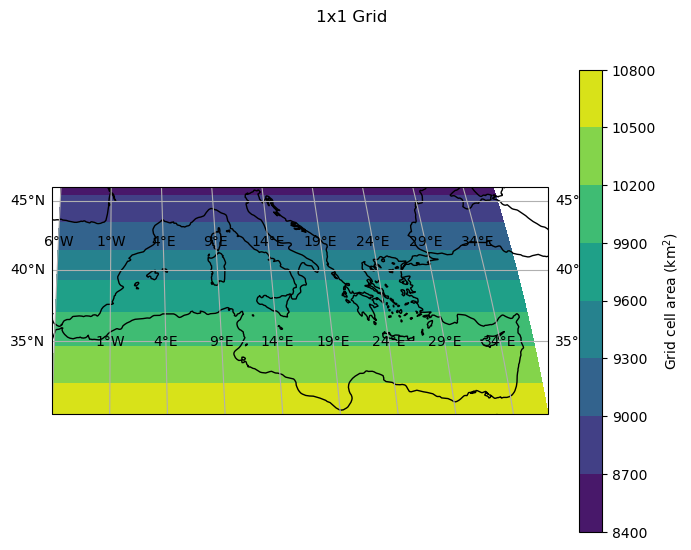

In [38]:
fig = plt.figure(figsize=(8,6))
# define a new projection for your region.
ax = plt.axes(projection=ccrs.Mollweide())
# the extent is set in longitude/latitude, i.e. in projection "PlateCarree"
ax.set_extent([-6, 37, 30, 46], crs=ccrs.PlateCarree())
# test this projection
# `transform` gives the information of the *data projection*
# the *plot projection* is defined above
plt.contourf(lon1d, lat1d, marea2d, transform=data_crs)
plt.colorbar(label='Grid cell area (km$^{2}$)')
ax.coastlines(resolution='50m')
ax.gridlines(xlocs=np.arange(-6, 37, 5), ylocs=np.arange(30, 46, 5), draw_labels=True, crs=data_crs)
title = fig.suptitle('1x1 Grid')

**Q1.3.4** Adaptez la fonction `shade` ci-dessus pour votre nouvelle projection, en incluant les parallèles et méridiens.

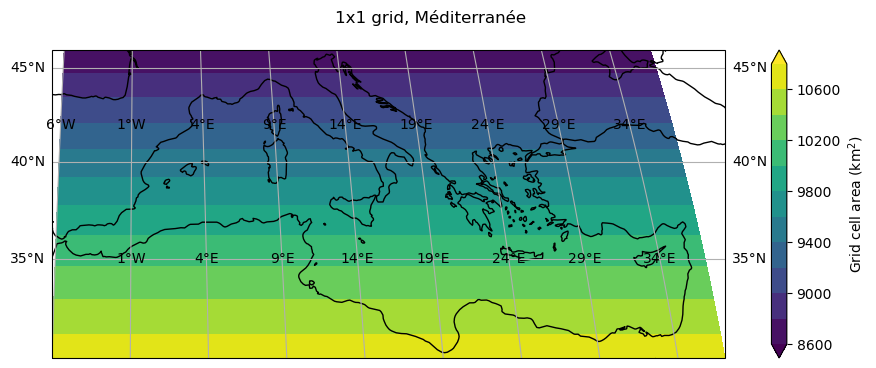

In [39]:
def shade(var2d, var_name='', units='', title='', vmin=None, vmax=None, delta=None, cmap=None, extend='both'):
    """Shade the 2-dimensional variable var2d with a nice projection and colorbar.
    Parameters
    ----------
    var2d : np.array or xarray
        2-dimensional array
    var_name : str, optional
        Name of the ploted variable.
    units : str, optional
        Units of the ploted variable.
    title : str, optional
        Title of the graph. Should describe the specificities of the graph (model, period, etc.).
    vmin : real, default: minimum of var2d
        Minimum value of the colorbar.
    vmax : real, default: maximum of var2d
        Maximum value of the colorbar.
    delta : real, default: var2d range (max - min) divided by 10
        Increment of the colorbar.
    cmap : str, default: default matplotlib cmap 'viridis'
        Name of the colormap.
    extend : str
        Define the extremity of the colorbar, can be 'min' or 'max' or 'both' or 'neither'
    Returns
    -------
    a matplotlib figure
    """
    fig = plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=ccrs.Mollweide())
    ax.set_extent([-6, 37, 30, 46], crs=ccrs.PlateCarree())
    # define the colorbar
    vmin = var2d.min() if vmin is None else vmin
    vmax = var2d.max() if vmax is None else vmax
    # default delta give 10 increments from vmin to vmax
    delta = (vmax - vmin) / 10. if delta is None else delta
    levels = np.arange(vmin, vmax + delta, delta)
    # plot
    plt.contourf(lon1d, lat1d, var2d, levels, vmin=vmin, vmax=vmax, extend=extend, cmap=cmap, transform=data_crs)
    plt.colorbar(label=var_name + ' (' + units + ')')
    ax.coastlines()
    ax.gridlines(xlocs=np.arange(-6, 37, 5), ylocs=np.arange(30, 46, 5), draw_labels=True, crs=data_crs)
    fig.suptitle(title)


# test your new shade function
shade(marea2d, var_name='Grid cell area', units='km$^{2}$', title='1x1 grid, Méditerranée',\
      vmin=8600, vmax=10800, delta=200, extend="both")

## 1.4. Faire une carte climatologique

Le vif du sujet. Ici on commence par lire les données climatiques contenues dans les fichiers netcdf stockés dans le dossier `./in/`. Ces fichiers contiennent les valeurs annuelles (`*1x1_annual.nc4`) et saisonnières (`DJF` et `JJA`) pour la période "historical" (1850-20114) et la projection "ssp585" (2015-2100). Les deux périodes ont été concaténées dans un seul fichier pour plus de facilité.

Pour la période "historical", les forçages radiatifs des modèles de climat couplés océan-atmosphère sont basés sur des valeurs observées. Pour les projections "ssp585", les forçages radiatifs augmentent de +8,5 W/m2 entre la fin du 20ème siècle et la fin du 21ème siècle, ce qui correspond à continuer sur notre trajectoire actuelle d'émission de gaz à effet de serre (["business-as-usual"](https://fr.wikipedia.org/wiki/Trajectoires_socio-%C3%A9conomiques_partag%C3%A9es)).

Nous avons sélectionné 5 modèles de climats globaux (GCMs = Global Climate Models) de l'ensemble CMIP6, en fonction de leur sensibilité climatique à l'équilibre ([ECS](https://en.wikipedia.org/wiki/Climate_sensitivity#Equilibrium_climate_sensitivity), i.e. augmentation de température moyenne globale pour un doublement du CO2) :
    - NorESM2-MM : ECS = 2.5
    - GISS-E2-1-G : ECS = 2.7
    - MPI-ESM1-2-HR : ECS = 3.0
    - CNRM-CM6-1-HR : ECS = 4.3
    - IPSL-CM6A-LR : ECS = 4.6

Pour commencer :
* sélectionnez votre variable
* choisissez les valeurs annuelles : `season = 'annual'`. Vous pourrez tester les saisons `DJF` et `JJA` ensuite.
* sélectionnez un modèle, appelé `gcm` = global climate model. Vous pourrez tester différents gcm ensuite.

In [40]:
# select your variable and your list of GCMs
var_name = 'pr'  # 'pr' or 'tas' or 'tos' or 'siconc'
season = 'annual'  # 'annual' or 'DJF' or 'JJA'
gcm = 'CNRM-CM6-1-HR'  # 'CNRM-CM6-1-HR' or 'MPI-ESM1-2-HR' or 'GISS-E2-1-G'  or 'IPSL-CM6A-LR' or 'NorESM2-MM'

In [41]:
# define the name of the file
file_in = './in/' + var_name + '/' + var_name + '_' + gcm + '_historical-ssp585_1850-2100_1x1_' + season + '.nc'

In [42]:
# read variable
var3d_in = xr.open_dataset(file_in)[var_name]
# reformat time axis (for calendar issues)
year_min, year_max = var3d_in['time.year'].min(), var3d_in['time.year'].max()
time1d = np.array([datetime.datetime(year, 1, 1) for year in np.arange(year_min, year_max + 1)])
# remove NaN
var3d_in = var3d_in.where(var3d_in < 9999.)
var3d_in = var3d_in.where(var3d_in > -9999.)

In [43]:
# check what's in var3d_in
var3d_in

<xarray.DataArray 'pr' (time: 251, lat: 181, lon: 361)>
array([[[2.25174335e-06, 2.25174335e-06, 2.25174335e-06, ...,
         2.25174335e-06, 2.25174335e-06, 2.25174335e-06],
        [2.19951312e-06, 2.19951312e-06, 2.19951312e-06, ...,
         2.19951312e-06, 2.19951312e-06, 2.19951312e-06],
        [1.30220587e-06, 1.30220587e-06, 1.30220587e-06, ...,
         1.30220587e-06, 1.30220587e-06, 1.30220587e-06],
        ...,
        [7.23501762e-06, 7.23501762e-06, 7.23501762e-06, ...,
         7.23501762e-06, 7.23501762e-06, 7.23501762e-06],
        [7.26005828e-06, 7.26005828e-06, 7.26005828e-06, ...,
         7.26005828e-06, 7.26005828e-06, 7.26005828e-06],
        [6.55172698e-06, 6.55172698e-06, 6.55172698e-06, ...,
         6.55172698e-06, 6.55172698e-06, 6.55172698e-06]],

       [[2.70967348e-06, 2.70967348e-06, 2.70967348e-06, ...,
         2.70967348e-06, 2.70967348e-06, 2.70967348e-06],
        [3.02680087e-06, 3.02680087e-06, 3.02680087e-06, ...,
         3.02680087e-06, 3.02680087e-06, 3.02680087e-06],
        [1.57093655e-06, 1.57093655e-06, 1.57093655e-06, ...,
         1.57093655e-06, 1.57093655e-06, 1.57093655e-06],
...
        [1.17764912e-05, 1.17764912e-05, 1.17764912e-05, ...,
         1.17764912e-05, 1.17764912e-05, 1.17764912e-05],
        [1.13736241e-05, 1.13736241e-05, 1.13736241e-05, ...,
         1.13736241e-05, 1.13736241e-05, 1.13736241e-05],
        [1.15448274e-05, 1.15448274e-05, 1.15448274e-05, ...,
         1.15448274e-05, 1.15448274e-05, 1.15448274e-05]],

       [[3.78857726e-06, 3.78857726e-06, 3.78857726e-06, ...,
         3.78857726e-06, 3.78857726e-06, 3.78857726e-06],
        [3.85401972e-06, 3.85401972e-06, 3.85401972e-06, ...,
         3.85401972e-06, 3.85401972e-06, 3.85401972e-06],
        [3.41644227e-06, 3.41644227e-06, 3.41644227e-06, ...,
         3.41644227e-06, 3.41644227e-06, 3.41644227e-06],
        ...,
        [1.35625669e-05, 1.35625669e-05, 1.35625669e-05, ...,
         1.35625669e-05, 1.35625669e-05, 1.35625669e-05],
        [1.35386717e-05, 1.35386717e-05, 1.35386717e-05, ...,
         1.35386717e-05, 1.35386717e-05, 1.35386717e-05],
        [1.20046225e-05, 1.20046225e-05, 1.20046225e-05, ...,
         1.20046225e-05, 1.20046225e-05, 1.20046225e-05]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-07-01T06:00:00 ... 2100-07-01T06:00:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    standard_name:       precipitation_flux
    long_name:           Precipitation
    units:               kg m-2 s-1
    cell_methods:        area: time: mean
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

In [44]:
# check what's in time1d
time1d

array([datetime.datetime(1850, 1, 1, 0, 0),
       datetime.datetime(1851, 1, 1, 0, 0),
       datetime.datetime(1852, 1, 1, 0, 0),
       datetime.datetime(1853, 1, 1, 0, 0),
       datetime.datetime(1854, 1, 1, 0, 0),
       datetime.datetime(1855, 1, 1, 0, 0),
       datetime.datetime(1856, 1, 1, 0, 0),
       datetime.datetime(1857, 1, 1, 0, 0),
       datetime.datetime(1858, 1, 1, 0, 0),
       datetime.datetime(1859, 1, 1, 0, 0),
       datetime.datetime(1860, 1, 1, 0, 0),
       datetime.datetime(1861, 1, 1, 0, 0),
       datetime.datetime(1862, 1, 1, 0, 0),
       datetime.datetime(1863, 1, 1, 0, 0),
       datetime.datetime(1864, 1, 1, 0, 0),
       datetime.datetime(1865, 1, 1, 0, 0),
       datetime.datetime(1866, 1, 1, 0, 0),
       datetime.datetime(1867, 1, 1, 0, 0),
       datetime.datetime(1868, 1, 1, 0, 0),
       datetime.datetime(1869, 1, 1, 0, 0),
       datetime.datetime(1870, 1, 1, 0, 0),
       datetime.datetime(1871, 1, 1, 0, 0),
       datetime.datetime(1872, 1

In [45]:
# have a quick look of the first time step of var3d
var3d_in[0,:,:]

<xarray.DataArray 'pr' (lat: 181, lon: 361)>
array([[2.2517434e-06, 2.2517434e-06, 2.2517434e-06, ..., 2.2517434e-06,
        2.2517434e-06, 2.2517434e-06],
       [2.1995131e-06, 2.1995131e-06, 2.1995131e-06, ..., 2.1995131e-06,
        2.1995131e-06, 2.1995131e-06],
       [1.3022059e-06, 1.3022059e-06, 1.3022059e-06, ..., 1.3022059e-06,
        1.3022059e-06, 1.3022059e-06],
       ...,
       [7.2350176e-06, 7.2350176e-06, 7.2350176e-06, ..., 7.2350176e-06,
        7.2350176e-06, 7.2350176e-06],
       [7.2600583e-06, 7.2600583e-06, 7.2600583e-06, ..., 7.2600583e-06,
        7.2600583e-06, 7.2600583e-06],
       [6.5517270e-06, 6.5517270e-06, 6.5517270e-06, ..., 6.5517270e-06,
        6.5517270e-06, 6.5517270e-06]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1850-07-01T06:00:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    standard_name:       precipitation_flux
    long_name:           Precipitation
    units:               kg m-2 s-1
    cell_methods:        area: time: mean
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    cell_measures:       area: areacella

In [46]:
# Variables readable names and units
name = {'pr': 'precipitation',
        'tas': 'surface air temperature',
        'tos': 'surface ocean temperature',
        'siconc': 'sea ice cover'}
units = {'pr': 'kg m-2 yr-1',
         'tas': 'C',
         'tos': 'C',
         'siconc': '%'}

In [47]:
# convert your variable into the readable unit given above
add_constant = 0.
mult_constant = 1.
if var_name == 'pr':
    # kg m-2 s-1 -> kg m-2 yr-1
    mult_constant = 3600 * 24 * 365.25
elif var_name in ('tas', 'tos'):
    # K -> degC
    add_constant = -273.15

# change unit
var3d = var3d_in * mult_constant + add_constant

In [48]:
# change the `units` attribute of your variable
var3d.attrs["units"] = units[var_name]

In [49]:
# check your variable
var3d

<xarray.DataArray 'pr' (time: 251, lat: 181, lon: 361)>
array([[[ 71.059616,  71.059616,  71.059616, ...,  71.059616,
          71.059616,  71.059616],
        [ 69.411354,  69.411354,  69.411354, ...,  69.411354,
          69.411354,  69.411354],
        [ 41.094494,  41.094494,  41.094494, ...,  41.094494,
          41.094494,  41.094494],
        ...,
        [228.3198  , 228.3198  , 228.3198  , ..., 228.3198  ,
         228.3198  , 228.3198  ],
        [229.11002 , 229.11002 , 229.11002 , ..., 229.11002 ,
         229.11002 , 229.11002 ],
        [206.75677 , 206.75677 , 206.75677 , ..., 206.75677 ,
         206.75677 , 206.75677 ]],

       [[ 85.510796,  85.510796,  85.510796, ...,  85.510796,
          85.510796,  85.510796],
        [ 95.51857 ,  95.51857 ,  95.51857 , ...,  95.51857 ,
          95.51857 ,  95.51857 ],
        [ 49.574986,  49.574986,  49.574986, ...,  49.574986,
          49.574986,  49.574986],
...
        [371.6378  , 371.6378  , 371.6378  , ..., 371.6378  ,
         371.6378  , 371.6378  ],
        [358.9243  , 358.9243  , 358.9243  , ..., 358.9243  ,
         358.9243  , 358.9243  ],
        [364.32706 , 364.32706 , 364.32706 , ..., 364.32706 ,
         364.32706 , 364.32706 ]],

       [[119.5584  , 119.5584  , 119.5584  , ..., 119.5584  ,
         119.5584  , 119.5584  ],
        [121.62361 , 121.62361 , 121.62361 , ..., 121.62361 ,
         121.62361 , 121.62361 ],
        [107.81472 , 107.81472 , 107.81472 , ..., 107.81472 ,
         107.81472 , 107.81472 ],
        ...,
        [428.00208 , 428.00208 , 428.00208 , ..., 428.00208 ,
         428.00208 , 428.00208 ],
        [427.248   , 427.248   , 427.248   , ..., 427.248   ,
         427.248   , 427.248   ],
        [378.83707 , 378.83707 , 378.83707 , ..., 378.83707 ,
         378.83707 , 378.83707 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-07-01T06:00:00 ... 2100-07-01T06:00:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    units:    kg m-2 yr-1

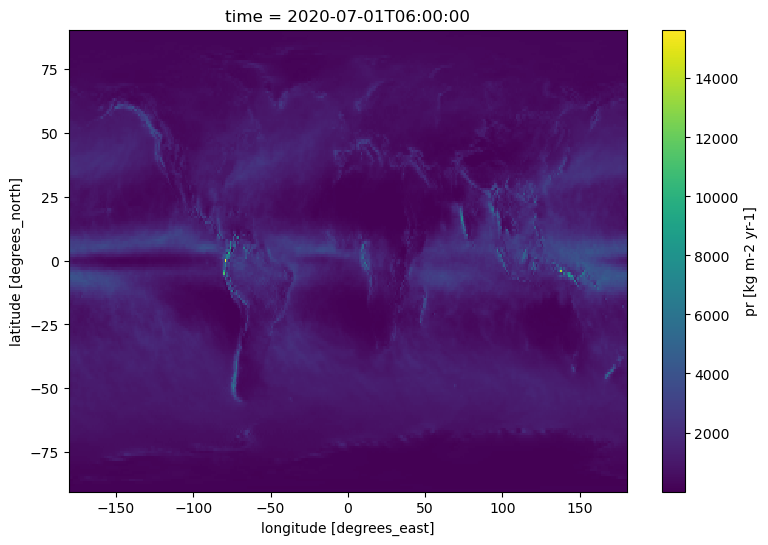

In [50]:
# have again a quick view of your variable
var3d.sel(time='2020').plot()

**Q1.4.1** Calculer la moyenne historique pour 20 ans (1980-2000) de votre variable (=climatologie)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False Fa

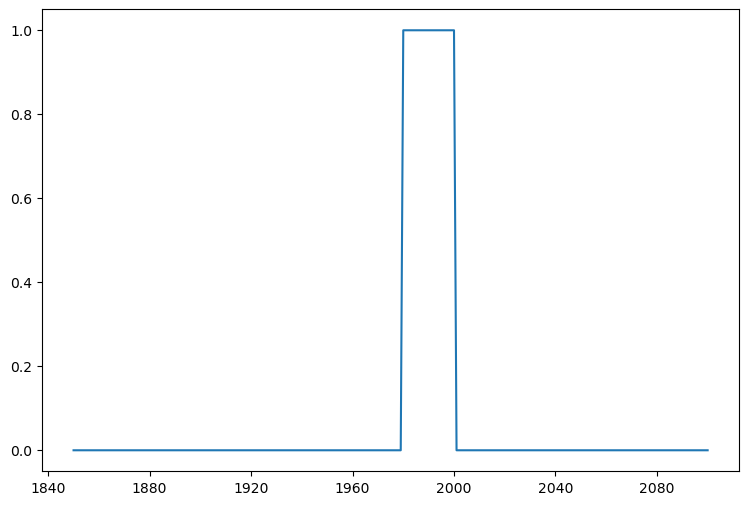

In [51]:
# define a time period
year_min, year_max = 1980, 2000
# define a boolean equal to True between the two years
period = (time1d >= datetime.datetime(year_min, 1, 1)) & (time1d < datetime.datetime(year_max+1, 1, 1))
print(period)
# have a look to the period
plt.plot(time1d, period)

In [52]:
# average the gcm for this period
var2d = var3d[period].mean('time')

In [53]:
# have a quick look on var2d
print(var2d)

<xarray.DataArray 'pr' (lat: 181, lon: 361)>
array([[ 82.84201 ,  82.84201 ,  82.84201 , ...,  82.84201 ,  82.84201 ,
         82.84201 ],
       [ 82.206825,  82.206825,  82.206825, ...,  82.206825,  82.206825,
         82.206825],
       [ 51.891933,  51.891933,  51.891933, ...,  51.891933,  51.891933,
         51.891933],
       ...,
       [215.23552 , 215.23552 , 215.23552 , ..., 215.23552 , 215.23552 ,
        215.23552 ],
       [219.90736 , 219.90736 , 219.90736 , ..., 219.90736 , 219.90736 ,
        219.90736 ],
       [206.30682 , 206.30682 , 206.30682 , ..., 206.30682 , 206.30682 ,
        206.30682 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0


**Q1.4.2** Masquez votre variable 2d (moyenne sur 20 ans) partout sauf sur votre région.

In [54]:
# mask the data outside your region
mvar2d = var2d.where(region2d)

In [55]:
# have a quick look on mvar2d
print(mvar2d)

<xarray.DataArray 'pr' (lat: 181, lon: 361)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0


**Q1.4.3** Faites une carte de la climatologie de votre variable en utilisant votre fonction `shade`, avec un **titre correct**, une **échelle de couleur correcte** et une **colormap correcte** (https://matplotlib.org/users/colormaps.html). Vous pouvez, par exemple, utiliser les colormap suivantes :
- 'pr':'YlGnBu'
- 'tas':'YlOrRd'
- 'tos':'YlOrRd'
- 'siconc': 'Blues_r'

In [56]:
# choose your colormap
cmap = 'YlGnBu'

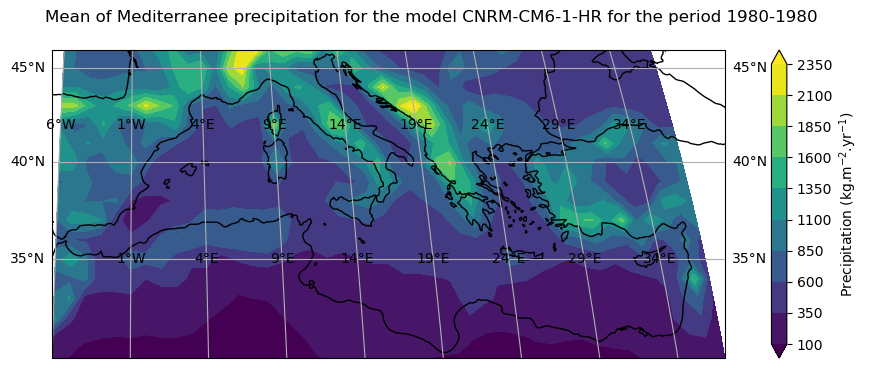

In [57]:
# plot mvar2d using your shade function, with a **nice title** and a **nice colorbar**
title = 'Mean of '+ reg_name + ' ' + name[var_name] + ' for the model '+ gcm + ' for the period ' + str(year_min) \
         + '-' + str(year_min)
vmin, vmax, delta = 100, 2300, 250
shade(mvar2d, var_name='Precipitation', units=r'kg.m$^{-2}$.yr$^{-1}$', title=title,\
      vmin=vmin, vmax=vmax, delta=delta, extend="both")
# save your figure in the ./fig/ directory
fig_name = './fig/' + gcm + '_time-average_' + str(year_min) + '-' + str(year_max) + '_' + season + '.png'
plt.savefig(fig_name, dpi=300)

---
### Questions bonus TD2

- **Qbonus2.a** Refaire cette carte climatologique pour différents GCMs, avec la même échelle de couleur pour tous les gcm si possible.
- **Qbonus2.b** Refaire cette carte climatologique pour l'été et l'hiver, avec la même échelle de couleur pour toutes les saisons.

## La magie des dictionnaires
Pour répondre aux questions bonus, vous pouvez au choix :
1. refaire tourner votre notebook en changeant le nom du modèle (`gcm`) et le nom de la saison (`season`) à la section 1.4
2. créer un dictionnaire, c'est à dire une variable indexée par des mots : voir exemple ci-dessous

In [58]:
# define your dictionary keys
gcm_list = 'CNRM-CM6-1-HR', 'MPI-ESM1-2-HR', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'NorESM2-MM'
season_list = 'annual', 'DJF', 'JJA'

In [59]:
# initialize dictionaries, which depend on GCMs and seasons and contain empty arrays
var3d_dict = {gcm_name: {
        season_name: xr.DataArray([]) for season_name in season_list
                } for gcm_name in gcm_list}

time1d_dict = {gcm_name: {
        season_name: xr.DataArray([]) for season_name in season_list
                } for gcm_name in gcm_list}

In [60]:
# convertion factors for your variable
add_constant = 0.
mult_constant = 1.
if var_name == 'pr':
    # kg m-2 s-1 -> kg m-2 yr-1
    mult_constant = 3600 * 24 * 365.25
elif var_name in ('tas', 'tos'):
    # K -> degC
    add_constant = -273.15

# read the netcdf files and put the data in dictionaries
for gcm_name in gcm_list:
    for season_name in season_list:
        print(gcm_name, season_name)
        # define the name of the file
        file_in = './in/' + var_name + '/' + var_name + '_' + gcm_name + '_historical-ssp585_1850-2100_1x1_' + season_name + '.nc'
        # read variable and put it in the dictionary
        var3d_dict[gcm_name][season_name] = xr.open_dataset(file_in)[var_name]
        # reformat time axis (for calendar issues)
        year_min, year_max = var3d_dict[gcm_name][season_name]['time.year'].min(), var3d_dict[gcm_name][season_name][
            'time.year'].max()
        time1d_dict[gcm_name][season_name] = np.array([datetime.datetime(year, 1, 1) for year in np.arange(year_min, year_max + 1)])
        # remove NaN
        var3d_dict[gcm_name][season_name] = var3d_dict[gcm_name][season_name].where(
            var3d_dict[gcm_name][season_name] < 9999.)
        var3d_dict[gcm_name][season_name] = var3d_dict[gcm_name][season_name].where(
            var3d_dict[gcm_name][season_name] > -9999.)
        # change unit
        var3d_dict[gcm_name][season_name] = var3d_dict[gcm_name][season_name] * mult_constant + add_constant
        # change the `units` attribute of your variable
        var3d_dict[gcm_name][season_name].attrs["units"] = units[var_name]

CNRM-CM6-1-HR annual
CNRM-CM6-1-HR DJF
CNRM-CM6-1-HR JJA
MPI-ESM1-2-HR annual
MPI-ESM1-2-HR DJF
MPI-ESM1-2-HR JJA
GISS-E2-1-G annual
GISS-E2-1-G DJF
GISS-E2-1-G JJA
IPSL-CM6A-LR annual
IPSL-CM6A-LR DJF
IPSL-CM6A-LR JJA
NorESM2-MM annual
NorESM2-MM DJF
NorESM2-MM JJA


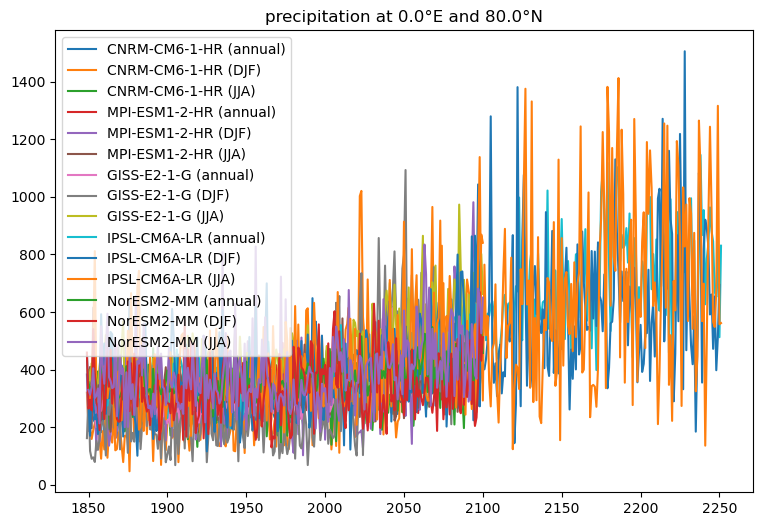

In [61]:
# and after you can do a loop on `gcm_name` and `season_name`, an example:
for gcm_name in gcm_list:
    for season_name in season_list:
        # just as an example
        # WARNING : this plot is just an example, it must be improved for readability
        lon, lat = 0., 80.
        plt.plot(time1d_dict[gcm_name][season_name], var3d_dict[gcm_name][season_name].sel(lon=lon, lat=lat, method='nearest'),
                 label=gcm_name + ' (' + season_name + ')')
plt.title(name[var_name] + ' at ' + str(lon) +'°E and ' + str(lat) + '°N')
plt.legend()

# ===== END OF TD2 =====

---
# Partie 2. Calculer et tracer des séries temporelles

Le but de cette partie est de visualiser comment évolue votre variable en moyenne sur votre domaine, entre 1850 et 2100 pour le scénario "historical"+"rcp85". Pour cela il faut faire une moyenne de votre variable sur votre région, qui doit **être pondérée par l'aire des cellules**. Nous travaillons sur les moyennes annuel car l'amplitude du cycle saisonnier peut masquer le signal climatique. Mais il est recommandé de travailler regarder aussi l'évolution par saison (DJF et JJA) pour évaluer les contributions saisonnières au signal annuel.

Idéalement ce travail devra être fait pour plusieurs GCMs, mais nous nous concentrerons sur un seul GCM pour commencer.

## 2.1. Moyenne spatiale et série temporelle annuelle

**Q2.1.1** Faire une carte de la variable 3d masquée pour votre région pour une année donnée, avec un titre et une jolie colormap, et les valeurs vmin/vmax qui vont bien, en utilisant votre fonction `shade`.

In [62]:
# mask the data over your region
mvar3d = var3d.where(region2d)

In [63]:
# have a quick look on mvar3d for one year
print(mvar3d.sel(time='2020'))

<xarray.DataArray 'pr' (time: 1, lat: 181, lon: 361)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-07-01T06:00:00
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Attributes:
    units:    kg m-2 yr-1


In [64]:
# define mvar2d = mvar3d for the year of your choice. Tip: use .squeeze() to remove the time dimension
year = '2000'
mvar2d = mvar3d.sel(time=year).squeeze()

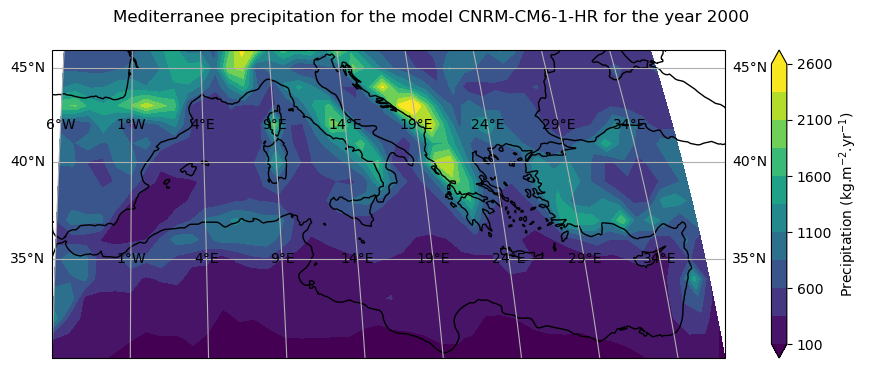

In [65]:
# plot mvar3d for the year of your choice, with a title and a nice colormap
year = '2000'
mvar2d = mvar3d.sel(time=year).squeeze()
title = reg_name + ' ' + name[var_name] + ' for the model '+ gcm + ' for the year ' + year
vmin, vmax, delta = 100, 2500, 250
shade(mvar2d, var_name='Precipitation', units='kg.m$^{-2}$.yr$^{-1}$', title=title,\
      vmin=vmin, vmax=vmax, delta=delta, extend="both")

**Q2.2.2** Faire une moyenne spatiale : il faut **pondérer chaque cellule par l'aire de la cellule**.

In [66]:
# create a weighted variable 
mvar3d_weighted = mvar3d.weighted(area2d)

In [67]:
# check what's in mvar3d_weighted
print(mvar3d_weighted)

DataArrayWeighted with weights along dimensions: lat, lon


In [68]:
# mvar1d = var3d, masked for your region, weighted by grid cell area, and spatially averaged
mvar1d = mvar3d_weighted.mean(("lon", "lat"))

In [69]:
# check what's in mvar1d
print(mvar1d)

<xarray.DataArray 'pr' (time: 251)>
array([529.11865, 576.9853 , 601.1753 , 641.11   , 689.10034, 597.4647 ,
       636.5179 , 595.16986, 637.18854, 631.1234 , 601.7355 , 608.9943 ,
       600.13184, 609.18243, 585.5286 , 598.3239 , 605.601  , 590.0336 ,
       576.98706, 554.607  , 594.27325, 602.04736, 654.72754, 588.07227,
       659.72943, 655.3094 , 640.95056, 534.06165, 524.86804, 647.1717 ,
       552.28613, 512.82434, 600.7359 , 621.10254, 648.327  , 608.58   ,
       690.71906, 604.94135, 620.78284, 624.26807, 611.5498 , 538.48206,
       653.9049 , 627.8872 , 648.64154, 597.5154 , 555.1799 , 597.9817 ,
       643.3383 , 563.09644, 572.5802 , 566.27826, 635.7973 , 581.5166 ,
       588.56433, 591.54535, 561.57587, 627.96906, 528.4086 , 623.9078 ,
       581.4041 , 603.6971 , 566.8443 , 607.0848 , 620.40234, 551.3378 ,
       575.98956, 657.74786, 615.9385 , 631.52765, 606.70245, 625.1667 ,
       624.1057 , 598.831  , 657.1408 , 633.04944, 539.3682 , 536.68677,
       682.8868

In [70]:
# plot quickly what's in mvar1d
print(mvar1d)

<xarray.DataArray 'pr' (time: 251)>
array([529.11865, 576.9853 , 601.1753 , 641.11   , 689.10034, 597.4647 ,
       636.5179 , 595.16986, 637.18854, 631.1234 , 601.7355 , 608.9943 ,
       600.13184, 609.18243, 585.5286 , 598.3239 , 605.601  , 590.0336 ,
       576.98706, 554.607  , 594.27325, 602.04736, 654.72754, 588.07227,
       659.72943, 655.3094 , 640.95056, 534.06165, 524.86804, 647.1717 ,
       552.28613, 512.82434, 600.7359 , 621.10254, 648.327  , 608.58   ,
       690.71906, 604.94135, 620.78284, 624.26807, 611.5498 , 538.48206,
       653.9049 , 627.8872 , 648.64154, 597.5154 , 555.1799 , 597.9817 ,
       643.3383 , 563.09644, 572.5802 , 566.27826, 635.7973 , 581.5166 ,
       588.56433, 591.54535, 561.57587, 627.96906, 528.4086 , 623.9078 ,
       581.4041 , 603.6971 , 566.8443 , 607.0848 , 620.40234, 551.3378 ,
       575.98956, 657.74786, 615.9385 , 631.52765, 606.70245, 625.1667 ,
       624.1057 , 598.831  , 657.1408 , 633.04944, 539.3682 , 536.68677,
       682.8868

**Q2.1.3** Tracer les valeurs annuelles de votre variable en moyenne sur votre région, avec :
* plot `pyplot` à la place du plot `xarray`, pour mieux gérer les dates : `plt.plot(time1d, mvar1d, label=season)`
* titre : `plt.suptitle(title)`
* labels d'axes : `plt.xlabel(my_x_label)`, `plt.ylabel(my_y_label)`
* ajuster les limites d'axes x et y : `plt.xlim(xmin, xmax)`, `plt.ylim(ymin, ymax)`
    * -> pour xlim, comme `x` est un axe des temps, il faut définir les dates xmin et xmax avec `datetime.datetime(year, month, day)`

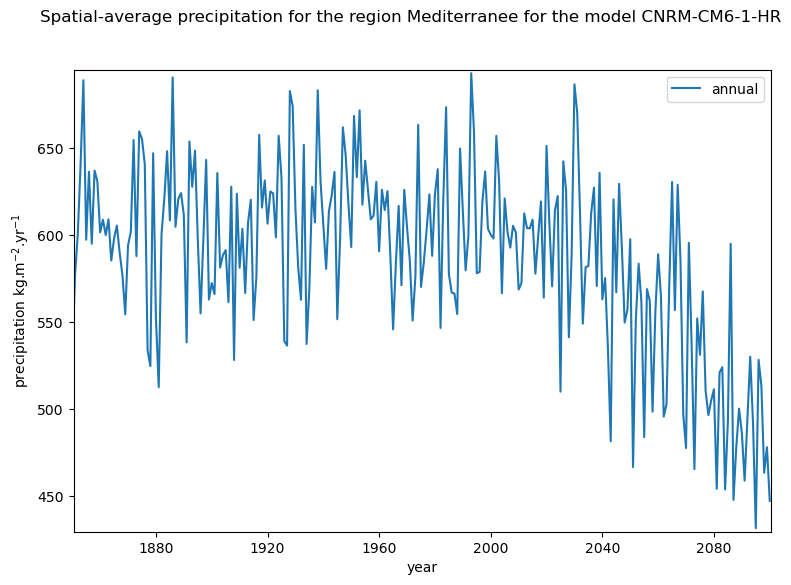

In [71]:
title = 'Spatial-average ' + name[var_name] + ' for the region ' + reg_name + ' for the model '+ gcm
plt.plot(time1d, mvar1d, label=season)
plt.legend()
plt.suptitle(title)
plt.xlabel('year')
plt.ylabel(name[var_name] + ' ' + 'kg.m$^{-2}$.yr$^{-1}$')
xmin, xmax = datetime.datetime(1850, 6, 15), datetime.datetime(2100, 6, 15)
period_full = (time1d >= xmin) & (time1d <= xmax)
ymin, ymax = mvar1d[period_full].min() - 2., mvar1d[period_full].max() + 2.
plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))
fig_name = './fig/' + gcm + '_ '+ reg_name + '_spatial-average_' + season + '.png'
plt.savefig(fig_name, dpi=300)

---
### Questions bonus TD3

- **Qbonus3.a** Ajouter sur le même graphe les moyennes saisonières d'été et d'hiver.
- **Qbonus3.b** Faire une figure avec uniquement les valeurs annuelles, mais montrant 3 GCMs.

**Alternative :** refaire ce graph pour différents gcm et différentes saisons, avec la même échelle verticale pour tous les graphs.

# ===== END OF TD3 =====
---

## 2.2. Statistiques climatiques et variabilité interne du climat

Ici vous estimerez les changements de votre variable pour des échelles de temps climatiques, c'est-à-dire sur des périodes de 20 à 30 ans. Vous calculerez une métrique permettant de quantifier la variabilité interne (ou "naturelle") du climat. Vous calculerez ensuite le "temps d'émergence", c'est-à-dire le moment où le signal de changement climatique sort de la variabilité naturelle du climat. 

---
**Résumé du calcul de la variabilité interne dans le cinquième rapport du GIEC (IPCC AR5)**

*Extrait du Chapitre 12 Box 12.1 p1041*

*A number of methods to indicate model robustness, involving an assessment of the significance of the change when compared to internal variability, have been proposed since AR4. The different methods share the purpose of identifying regions with large, significant or robust changes, regions with small changes, regions where models disagree or a combination of those. They do, however, use different assumptions about the statistical properties of the model ensemble, and therefore different criteria for synthesizing the information from it. Different methods also differ in the way they estimate internal variability. We briefly describe and compare several of these methods here.*

*Method (a): The default method used in Chapters 11,12 and 14 as well as in the Annex I (hatching only) is shown in Box 12.1, Figure 1a, and is based on relating the climate change signal to internal variability in 20-year means of the models as a reference[1] . Regions where the multi-model mean change exceeds **two standard deviations of internal variability** and where at least 90% of the models agree on the sign of change are stippled and interpreted as ‘large change with high model agreement’. Regions where the model mean is less than one standard deviation of internal variability are hatched and interpreted as ‘small signal or low agreement of models’. This can have various reasons: (1) changes in individual models are smaller than internal variability, or (2) although changes in individual models are significant, they disagree about the sign and the multi-model mean change remains small. Using this method, the case where all models scatter widely around zero and the case where all models agree on near zero change therefore are both hatched (e.g., precipitation change over the Amazon region by the end of the 21st century, which the following methods mark as ‘inconsistent model response’).*

*[1] The internal variability in this method is estimated using pre-industrial control runs for each of the models which are at least 500 years long. The first 100 years of the pre-industrial are ignored. Variability is calculated for every grid point as the standard deviation of non-overlapping 20-year means, multiplied by the square root of 2 to account for the fact that the variability of a difference in means is of interest. A quadratic fit as a function of time is subtracted from these at every grid point to eliminate model drift. This is by definition the standard deviation of the difference between two independent 20-year averages having the same variance and estimates the variation of that difference that would be expected due to unforced internal variability. The median across all models of that quantity is used.*

*Variability in methods b–d is estimated from **interannual variations in the base period (1986–2005)** within each model.*

---
Dans notre cas nous considèrerons :
- la période 1980-2000 comme notre **période de référence**. Vous devez vérifier si cette période est bien représentative du climat sur la période 1850-1980 ***Remarque du correcteur: il faut prendre une période plus longue, de 30 à 50 ans!***
- la variabilité interannuelle (i.e. l'écart type des valeurs interannuelles) de cette période de référence comme une mesure de la **variabilité interne**
- le **temps d'émergence** est défini comme l'année à partir de laquelle toutes les années sont en dehors de la variabilité interne par rapport à la période de référence.

**Q2.2.1** Calculer la valeur moyenne et la variabilité interannuelle (standard deviation, `std`) de votre variable régionale pour la période de référence `period_ref`. Inspirez-vous de ce qui a été fait plus haut.

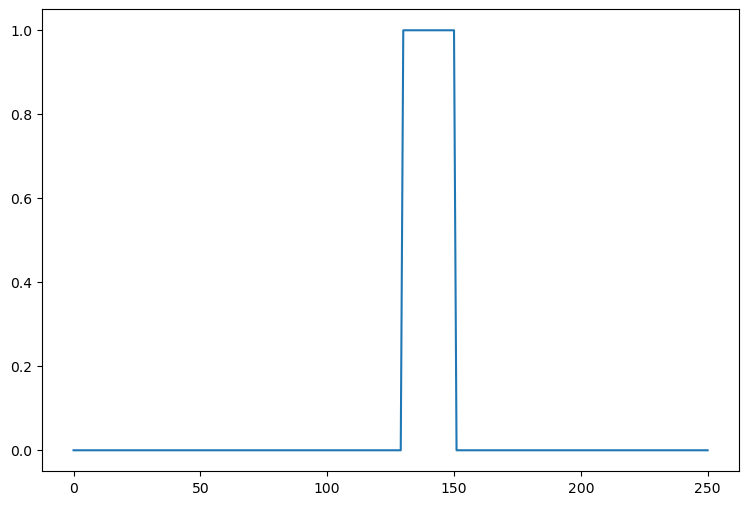

In [72]:
# reference period
duration = 30
year_max = 2000
year_min = year_max - duration
# define a boolean equal to True between the two years
period_ref = (mvar1d['time.year'] >= year_min) & (mvar1d['time.year'] <= year_max)
# have a quick look to this period
plt.plot(period)

In [73]:
# compute mean and standard deviation for this period
mean_ref = mvar1d[period].mean('time')
std_ref = mvar1d[period].std('time')

In [74]:
# print the mean and standard deviation for your period
label = str(year_min) + '-' + str(year_max) + ' : mean = ' + str(np.round(mean_ref.values, 1)) + ' ' + units[
    var_name] + '; std = ' + str(np.round(std_ref.values, 1)) + ' ' + units[var_name]
print(label)

1970-2000 : mean = 608.7 kg m-2 yr-1; std = 38.9 kg m-2 yr-1


**Q2.2.2** Représentez, vérifiez et ajustez votre période de référence. Commencez par tracer une boîte qui représente la variabilité interne autour de la moyenne pour la période de référence (2000-duration)-2000.

Text(0.5, 0.98, 'Mean of Mediterranee precipitation for the model CNRM-CM6-1-HR over the period 1970-2000')

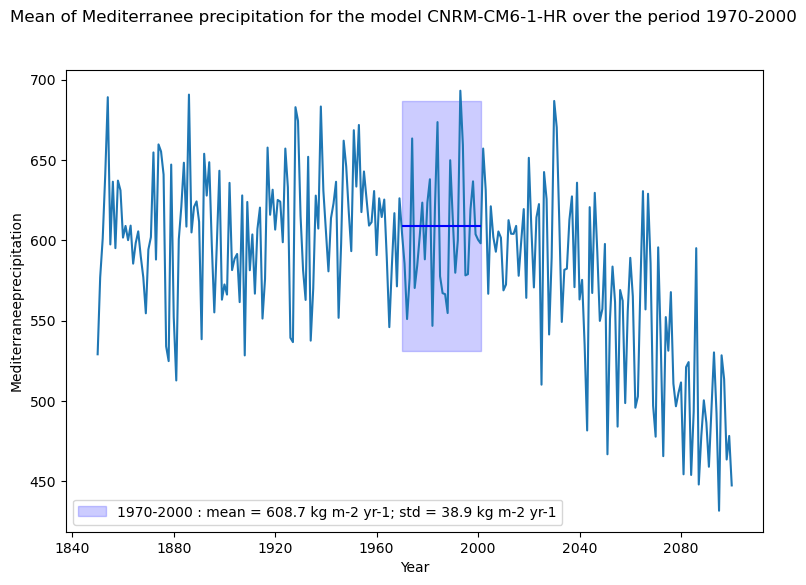

In [75]:
# a nice figure : add title, axes and labels
title = 'Mean of '+ reg_name + ' ' + name[var_name] + ' for the model '+ gcm +\
        ' over the period '+ str(year_min) +'-' + str(year_max)
# plot the time series
plt.plot(time1d, mvar1d)
# transform year in date
date_min, date_max = datetime.datetime(year_min, 1, 1), datetime.datetime(year_max, 12, 31)
# plot the mean over the period
plt.hlines(mean_ref, date_min, date_max, colors='b')
# shade 2 std around the mean
min_val, max_val = mean_ref - 2.0*std_ref, mean_ref + 2.0*std_ref
plt.fill_between([date_min, date_max], [min_val, min_val], [max_val, max_val], color='b', alpha=0.2, label=label)
plt.legend()
plt.xlabel('Year')
plt.ylabel(reg_name + name[var_name])
plt.suptitle(title)

On va maintenant automatiser cela pour vérifier visuellement la validité de cette période de référence. En fonction du graph obtenu, jouez avec les bornes de votre période de référence pour qu'elle représente le climat "stable" avant 1980 (l'allonger ? la reculer dans le temps ?).

In [76]:
def compute_time_mean_std(mvar1d, year_min, year_max):
    '''
    The time mean and std of the variable mvar1d for the period between year_min and year_max
    Parameters
    ----------
    mvar2d: np.array or xarray
        2-dimensional
    year_min: integer
        first year of the period
    year_max: integer
        last year of the period
    Returns
    -------
    real, real
        time mean, time std
    '''
    period = (mvar1d['time.year'] >= year_min) & (mvar1d['time.year'] <= year_max)
    # mean and standard deviation for this period
    tmean = mvar1d[period].mean("time")
    tstd = mvar1d[period].std("time")
    return tmean.values, tstd.values


def show_time_mean_std(mvar1d, year_min, year_max, color=''):
    '''
    Plot a box representing the mean and temporal variability over the period between year_min and year_max
    Parameters
    ----------
    mvar2d: np.array or xarray
        2-dimensional
    year_min: integer
        first year of the period
    year_max: integer
        last year of the period
    color: str (optional)
        color of the box
    Returns
    -------
    real, real
        time mean, time std
    '''
    # transform year in date
    date_min, date_max = datetime.datetime(year_min, 6, 15), datetime.datetime(year_max, 6, 15)
    # compute the mean, the std and the levels
    tmean, tstd = compute_time_mean_std(mvar1d, year_min, year_max)
    tmin, tmax = tmean - 2 * tstd, tmean + 2 * tstd
    # plot
    if color == '':
        # select a color depending of the year
        color = plt.get_cmap('viridis')((year_min - 1850) / 200)
    # label of the period
    label = str(year_min) + '-' + str(year_max) + ' : mean = ' + str(np.round(tmean, 1)) + ' ' + units[var_name] + '; std = ' + str(np.round(tstd, 1)) + ' ' + units[var_name]
    # plot the mean over the period with an horizontal line
    plt.hlines(tmean, date_min, date_max, colors='b')
    # shade 2 std around the mean
    plt.fill_between([date_min, date_max], [tmin, tmin], [tmax, tmax], color=color, alpha=0.2, label=label)
    return tmean, tstd

Text(0.5, 0.98, 'Mean of Mediterranee precipitation for the model CNRM-CM6-1-HR, annual')

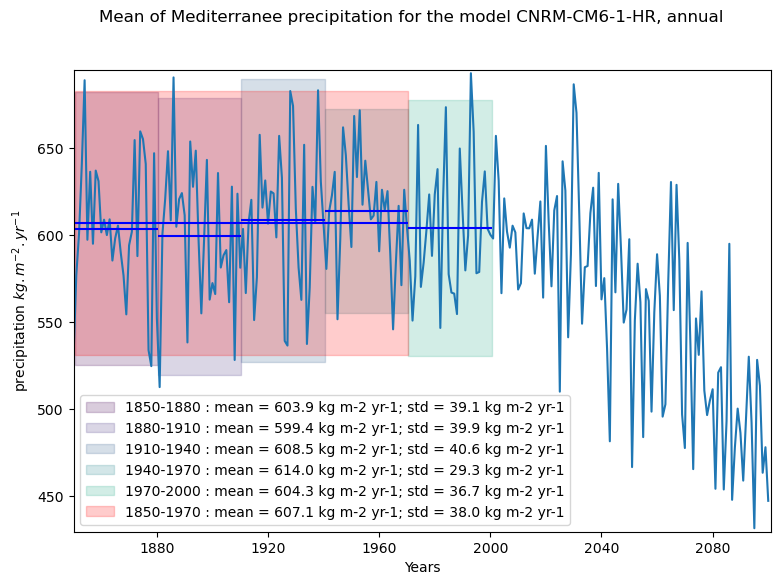

In [77]:
# a nice figure using these functions : add title, axes and labels
title = 'Mean of '+ reg_name + ' ' + name[var_name] + ' for the model '+ gcm + ', annual'
# plot the time series
plt.plot(time1d, mvar1d)
# plot duration-year boxes between 1850 and 2000
for year_min in np.arange(1850, 2000, duration):
    show_time_mean_std(mvar1d, year_min, year_min + duration)
# define the time extent of your plot
xmin, xmax = datetime.datetime(1850, 1, 1), datetime.datetime(2100, 12, 31)
period_full = (time1d >= xmin) & (time1d <= xmax)
ymin, ymax = mvar1d[period_full].min() - 2., mvar1d[period_full].max() + 2.
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# test your reference period and modify it
# ========================================
year_min, year_max = 1850, 2000-duration
show_time_mean_std(mvar1d, year_min, year_max, color='r')
plt.legend()
plt.xlabel('Years')
plt.ylabel(r'precipitation $kg.m^{-2}.yr^{-1}$')
plt.suptitle(title)

In [78]:
# define your final year_min, year_max for your reference period
year_max = 2000
year_min = year_max - duration
mean_ref, std_ref = compute_time_mean_std(mvar1d, year_min, year_max)

In [79]:
# print your reference mean and std
label = str(year_min) + '-' + str(year_max) + ' : mean = ' + str(np.round(mean_ref, 1)) + ' ' + units[
    var_name] + '; std = ' + str(np.round(std_ref, 1)) + ' ' + units[var_name]
print(label)

1970-2000 : mean = 604.3 kg m-2 yr-1; std = 36.7 kg m-2 yr-1


Text(0.5, 0.98, 'Mean of Mediterranee precipitation for the model CNRM-CM6-1-HR, annual')

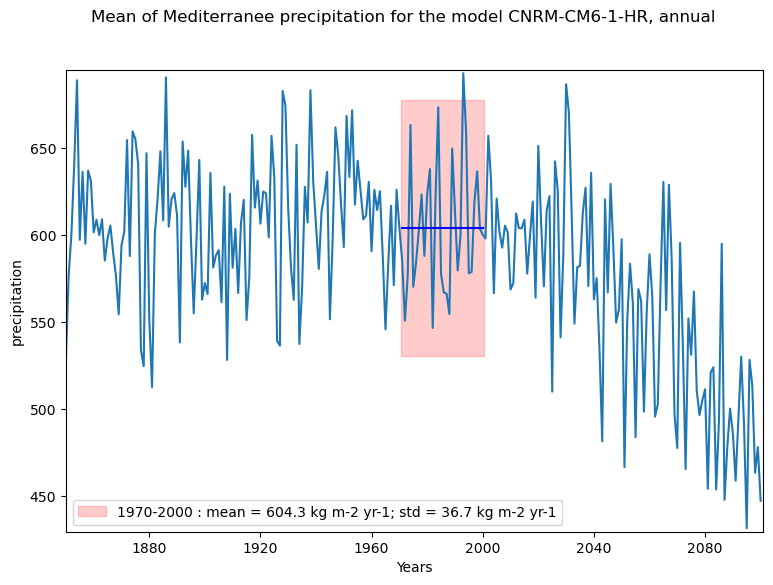

In [80]:
# show your final reference period
title = 'Mean of '+ reg_name + ' ' + name[var_name] + ' for the model '+ gcm + ', annual'
# plot the time series
plt.plot(time1d, mvar1d)
# define the time extent of your plot
xmin, xmax = datetime.datetime(1850, 1, 1), datetime.datetime(2100, 12, 31)
period_full = (time1d >= xmin) & (time1d <= xmax)
ymin, ymax = mvar1d[period_full].min() - 2., mvar1d[period_full].max() + 2.
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# test your reference period and modify it
# ========================================
year_max = 2000
year_min = year_max - duration
show_time_mean_std(mvar1d, year_min, year_max, color='r')
plt.legend()
plt.xlabel('Years')
plt.ylabel('precipitation')
plt.suptitle(title)

**Q2.2.3** Calculez le temps d'émergence `toe`, c'est à dire l'année à partir de laquelle toutes les années sont en dehors de la variabilité interne par rapport à la période de référence.

In [81]:
# define a boolean equal to True when the condition of emergence is reached
emergence = (mvar1d < mean_ref - 2.0 * std_ref) | (mvar1d > mean_ref + 2.0 * std_ref)

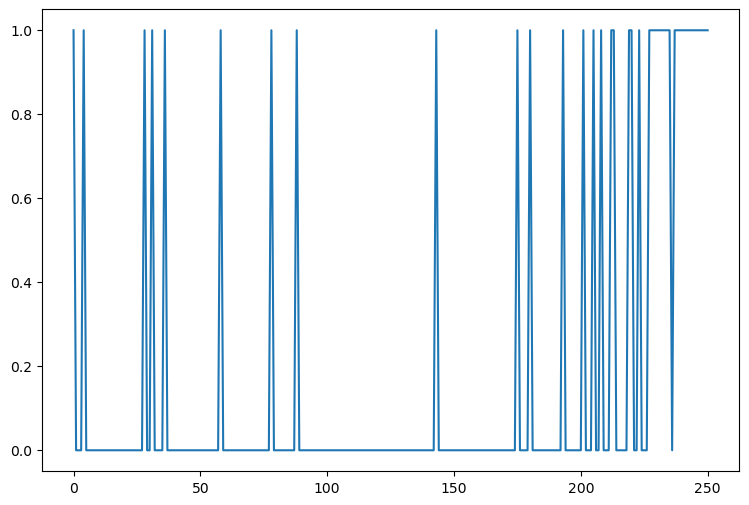

In [82]:
# have a quick look on emergence
plt.plot(emergence)

In [83]:
# find the year toe for which all the following years verify the condition of emergence
# on se place à la fin de la période
n = len(emergence)-1
# tant que la condition d'émergence est égale à 1 on recule dans le temps
while (n >=0) & emergence[n]:
    n -= 1
# si la période d'émergence est trop courte (inférieure à 10 ans), on décide qu'il n'y a pas d'émergence
# sinon, on affiche le temps d'émergence toe
if emergence['time.year'][-1].values - emergence['time.year'][n+1].values < 10:
    print('no time of emergence for ' + gcm)
else:
    toe = time1d[n+1]
    print('The time of emergence for ' + gcm + ' is: ' + str(toe))


The time of emergence for CNRM-CM6-1-HR is: 2087-01-01 00:00:00


**Q2.2.4** Représentez graphiquement le temps d'émergence en repartant de la figure précédente. Vous pouvez utiliser les fonctions `plt.hline`, `plt.vline`, `plt.annotate`

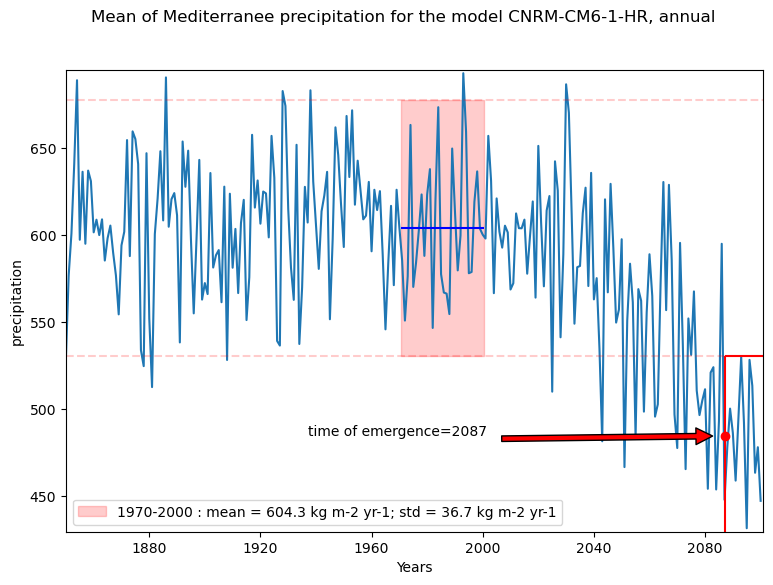

In [84]:
# show your final reference period
title = 'Mean of '+ reg_name + ' ' + name[var_name] + ' for the model '+ gcm + ', annual'
# plot the time series
plt.plot(time1d, mvar1d)
# define the time extent of your plot
xmin, xmax = datetime.datetime(1850, 1, 1), datetime.datetime(2100, 12, 31)
period_full = (time1d >= xmin) & (time1d <= xmax)
ymin, ymax = mvar1d[period_full].min() - 2., mvar1d[period_full].max() + 2.
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# reference period
# ================
year_max = 2000
year_min = year_max - duration
show_time_mean_std(mvar1d, year_min, year_max, color='r')
# toe
# ===
# Bounds over the whole period
plt.hlines(mean_ref - 2.0 * std_ref, xmin, xmax, color='r', linestyle='dashed', alpha=0.2)
plt.hlines(mean_ref + 2.0 * std_ref, xmin, xmax, color='r', linestyle='dashed', alpha=0.2)
# Bounds past toe
plt.hlines(mean_ref - 2.0 * std_ref, toe, xmax, color='r')
plt.vlines(toe, mean_ref - 2.0 * std_ref, ymin, color='r')
y_arrow = mvar1d[n+1] + std_ref
plt.plot(toe, y_arrow, 'or')
time_margin = datetime.timedelta(150*365,0,0,0)
plt.annotate('time of emergence=' + str(toe.year), xy=(toe, y_arrow), \
             xytext=(toe-time_margin, y_arrow), \
             arrowprops=dict(facecolor = 'red', shrink=0.05))
plt.legend()
plt.xlabel('Years')
plt.ylabel('precipitation')
plt.suptitle(title)
fig_name = './fig/' + gcm + '_ '+ reg_name + '_spatial-average_toe_' + season + '.png'
plt.savefig(fig_name, dpi=300)

## Questions bonus TD4
- **Qbonus4.a** : Faites la même figure pour d'autres GCMs
- **Qbonus4.b** : Faites la même figure pour l'été et/ou pour l'hiver

# ===== END OF TD4 =====
---

# 3. Carte du changement climatique projeté et de sa significativité
Au cours du TD3, vous réaliserez une carte du changement climatique modélisé entre la fin du 21ème siècle et la fin du 20ème siècle pour un GCM et le scénario rcp85, en hachurant les zones où le changement climatique est significatif, c'est à dire qu'il sort de la variabilité interne du climat.

**Q3.1.** Calculer les valeurs moyennes 2d pour la période future (fin du 21ème siècle: 2080-2100) et la période de référence (fin du 20ème siècle: 1980-2000)

In [85]:
# see Q1.3.1
# define the time periods
period_21c = (time1d >= datetime.datetime(2080, 1, 1)) & (time1d < datetime.datetime(2100+1, 1, 1))
period_20c = (time1d >= datetime.datetime(1980, 1, 1)) & (time1d < datetime.datetime(2000+1, 1, 1))
# average the gcm for these time periods
mvar2d_21c_mean = mvar3d[period_21c].mean('time').squeeze()
mvar2d_20c_mean = mvar3d[period_20c].mean('time').squeeze()

**Q3.2** Faire une carte de différence entre ces deux périodes en utilisant la fonction `shade`. Utiliser une palette de couleur centrée (voir https://matplotlib.org/users/colormaps.html) et des valeurs min et max centrées autour de `0`.

Recommandations de palettes de couleur :
* pour des températures et la glace de mer, 'RdBu_r'
* pour des précipitation, 'BrBG'

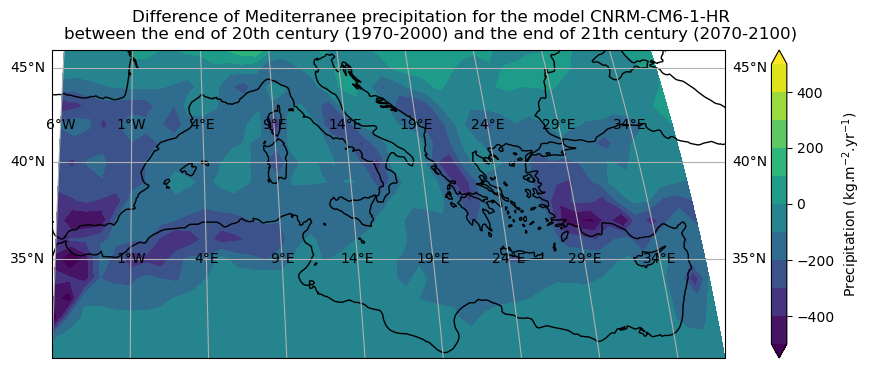

In [86]:
# plot a map of the difference between the periods
dvar2d = mvar2d_21c_mean - mvar2d_20c_mean
cmap = 'BrBG'
title = 'Difference of ' + reg_name + ' ' + name[var_name] + ' for the model '+ gcm +\
'\nbetween the end of 20th century (' + str(2000-duration) + '-2000) and the end of 21th century (' + \
str(2100-duration) + '-2100)'
vmin, vmax, delta = -500, 500, 100
shade(dvar2d, var_name='Precipitation', units='kg.m$^{-2}$.yr$^{-1}$', title=title,\
      vmin=vmin, vmax=vmax, delta=delta, extend="both")

**Q3.3** Montrer les zones où le changement climatique est significatif, en utilisant la même définition que pour la Section 2 : la différence de moyenne entre la fin du 21ème siècle et la fin du 20ème siècle est supérieur à 2 fois la variabilité interne. La variabilité interne est définie comme l'écart type des valeurs annuelles pour la fin du 20ème siècle.

In [87]:
# first define and look at the internal variability
mvar2d_20c_std = var3d[period_20c].std('time').squeeze().where(region2d)

In [88]:
# have a quick look at the spatial pattern of internal variability
print(mvar2d_20c_std)

<xarray.DataArray 'pr' (lat: 181, lon: 361)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0


In [89]:
# define a 2d variable equal to one where the change is significant, and equal to 0 elsewhere.
significant_change = np.abs(dvar2d) > 2.0 * mvar2d_20c_std

In [90]:
# have a quick look to the spatial extent of significant_change
print(significant_change)

<xarray.DataArray 'pr' (lat: 181, lon: 361)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0


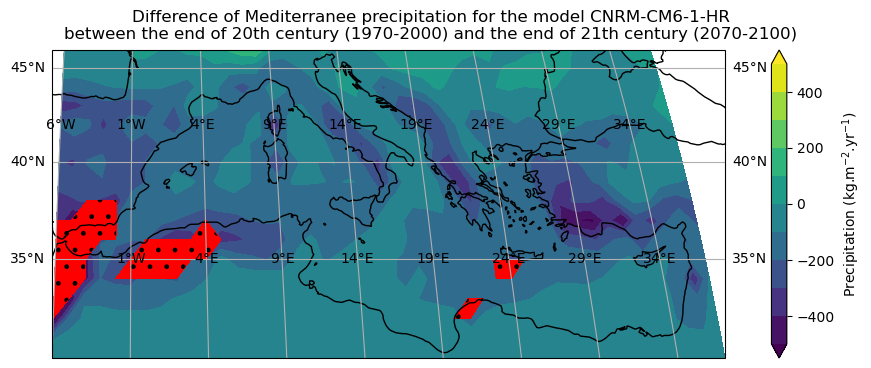

In [91]:
# then print dots
sig_change_dots = significant_change.where(significant_change)
shade(dvar2d, var_name='Precipitation', units='kg.m$^{-2}$.yr$^{-1}$', title=title,\
      vmin=vmin, vmax=vmax, delta=delta, extend="both")
plt.contourf(lon1d, lat1d, sig_change_dots, hatches='.', colors='red', transform=data_crs)
plt.savefig('./fig/' + gcm + '_map_climate-change_' + season + '.png', dpi=300)

Question complémentaire: Quelle est la variabilité spatiale de votre variable sur votre région pour la fin du 20ème siècle ? Cette variabilité spatialle vous semble-t-elle grande ou faible ?

In [92]:
flat = np.array(mvar2d_20c_mean.where(region2d)).flatten()
b = flat[np.logical_not(np.isnan(flat))]
print('Dispersion spatiale de la moyenne temporelle de la fin du 20ème siècle =', np.std(b), 'kg.m^{-2}.yr^{-1}')
print('Moyenne spatiale de la moyenne temporelle de la fin du 20ème siècle    =', np.mean(b), 'kg.m^{-2}.yr^{-1}')

Dispersion spatiale de la moyenne temporelle de la fin du 20ème siècle = 436.0989 kg.m^{-2}.yr^{-1}
Moyenne spatiale de la moyenne temporelle de la fin du 20ème siècle    = 626.5523 kg.m^{-2}.yr^{-1}


## Questions bonus TD5

- **Qbonus5.a** : Faites la même figure pour d'autres GCMs
- **Qbonus5.b** : Faites la même figure pour l'été et/ou pour l'hiver

# == The End ==
***